<h1 align=center><font size = 8> Clustering Neighborhoods in San Francisco by Venues</font></h1>

<h2 align=center><font size = 5> First Notebook</font></h2>

<font size = 5> **Author**: Angelo Di Marco

## Introduction

In this Notebook, we perform a cluster segmentation of the neighborhoods in San Francisco in terms of the venues categories which are most common in each neighborhood. We use the **Foursquare API** to explore the venues in each neighborhood and then we apply the __*k*-means__ clustering technique to group them into clusters.

**_Note_**: this is the *First Notebook* submitted for the "Capstone Project" of the *Applied Data Science Capstone* course, part of the **IBM Data Science Professional Certificate** issued by [Coursera.org](http://www.coursera.org).

**_Remark_**: notice that in order to have access to the venues of San Francisco neighborhoods and then to the main part of this Notebook, a *Foursquare Developer Account* is needed. This provides a Foursquare ID (CLIENT_ID) and a Foursquare Secret (CLIENT_SECRET) which are used to make Foursquare API calls.

**_Remark 2_**: notice that the results showed in this Notebook may change every time the Foursquare API are called and/or the clustering runs. This is due to the fact that Foursquare might give different results depending on when the API calls are done.

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Importing and Exploring Neighborhoods Dataset</a>

2. <a href="#item2">Foursquare Venues in San Francisco Neighborhoods</a>

3. <a href="#item3">Neighborhoods Clustering</a>

4. <a href="#item4">Sub-Clustering</a>

5. <a href="#item5">Merging Clusters and Sub-Clusters</a> 

6. <a href="#item6">Conclusions</a> 
</font>
</div>

## Libraries

In [1]:
import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# !conda install -c conda-forge geopy --yes # uncomment this line if you haven't installed the package yet
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt


from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium

print('Libraries imported.')

Libraries imported.


--------------------------

<a id='item1'></a>

## 1. Importing and Exploring Neighborhoods Dataset

## 1.1. San Francisco Neighborhoods

The city of San Francisco is usually divided in neighborhoods. Several divisions exist and they are used for different purposes. In this project, we will consider two of them. The first one is the so-called "Planning Neighborhood Groups Map", available at this [link](https://data.sfgov.org/Geographic-Locations-and-Boundaries/Planning-Neighborhood-Groups-Map/iacs-ws63). It offers a "fair" division of the area of the city which is more suitable for its use as for the Foursquare venues search, for instance. The second one, on the other hand, is called "Analysis Neighborhoods" (see the [link](https://data.sfgov.org/Geographic-Locations-and-Boundaries/Analysis-Neighborhoods/p5b7-5n3h)) and it is used, e.g., by the Police Department to locate the incidents occurring in San Francisco. In this Jupyter Notebook, we will focus on the first neighborhoods division since we are going to use it in combination with Foursquare API calls.

### "Planning Neighborhood Groups Map"

We first import the list of neighborhoods of San Francisco with the coordinates of their "centers" from the CSV file *SF_neighborhoods_latlon_ADM.csv* created by the author of this Notebook. We use *pandas* to convert it into a dataframe:

In [2]:
neighborhoods_SF_coord = pd.read_csv('SF_neighborhoods_latlon_ADM.csv', sep=';')
neighborhoods_SF_coord.head()

SF_neighborhoods   latitude   longitude
0          Seacliff  37.784973 -122.501423
1    Outer Richmond  37.777818 -122.492410
2  Golden Gate Park  37.769383 -122.481940
3      Outer Sunset  37.755419 -122.493805
4          Parkside  37.742096 -122.489641

In [3]:
neighborhoods_SF_coord.shape

(37, 3)

In [4]:
print('The dataframe has {} neighborhoods.'.format(
        len(neighborhoods_SF_coord['SF_neighborhoods'].unique())
    )
)

The dataframe has 37 neighborhoods.


We rename the columns of this dataframe

In [5]:
neighborhoods_SF_coord.rename(columns={'SF_neighborhoods':'Neighborhood','latitude':'Latitude','longitude':'Longitude'}, inplace=True)
neighborhoods_SF_coord.head()

Neighborhood   Latitude   Longitude
0          Seacliff  37.784973 -122.501423
1    Outer Richmond  37.777818 -122.492410
2  Golden Gate Park  37.769383 -122.481940
3      Outer Sunset  37.755419 -122.493805
4          Parkside  37.742096 -122.489641

In [6]:
neighborhoods_SF_coord['Neighborhood'].unique()

array(['Seacliff', 'Outer Richmond', 'Golden Gate Park', 'Outer Sunset',
       'Parkside', 'Lakeshore', 'Presidio', 'Inner Richmond',
       'Inner Sunset', 'West of Twin Peaks', 'Oceanview',
       'Presidio Heights', 'Haight-Ashbury', 'Twin-Peaks',
       'Outer Mission', 'Crocker Amazon', 'Marina', 'Pacific Heights',
       'Western Addition', 'Castro-Upper Market', 'Noe Valley',
       'Diamond Heights', 'Glen Park', 'Russian Hill', 'Nob Hill',
       'Downtown-Tenderloin', 'Mission', 'Bernal Heights', 'Excelsior',
       'Visitacion Valley', 'North Beach', 'Chinatown',
       'Financial District', 'South of Market', 'Potrero Hill', 'Bayview',
       'Treasure Island'], dtype=object)

At this point we want to create a __Choropleth map of San Francisco__ showing the "Planning Neighborhood Groups Map". We get the latitude and longitude of San Francisco using the Geopy library

In [7]:
address = 'San Francisco, California'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of San Francisco are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of San Francisco are 37.7790262, -122.4199061.


To create this kind of map first we load the GeoJson file containing the "borders" of the "Planning Neighborhood Groups Map" neighborhoods that can be downloaded from the [link](https://data.sfgov.org/Geographic-Locations-and-Boundaries/Planning-Neighborhood-Groups-Map/iacs-ws63). After few adjustments to the names of the neighborhoods of the original GeoJson file, we get the new file _SF_planning_neighborhood_groups_map_ADM.geojson_ and we import it as follows:

In [8]:
import os

san_francisco_geo_PN = os.path.join('...insert path...', 'SF_planning_neighborhood_groups_map_ADM.geojson')

We create a new dataframe with alphabetically ordered neighborhoods and with a reset index column to be used in the Choropleth map as follows:

In [9]:
neighborhoods_SF_coord_index = neighborhoods_SF_coord.sort_values(by='Neighborhood',ascending=True)
neighborhoods_SF_coord_index = neighborhoods_SF_coord_index.reset_index()
neighborhoods_SF_coord_index.drop(['index'],axis=1,inplace=True)
neighborhoods_SF_coord_index = neighborhoods_SF_coord_index.reset_index()
neighborhoods_SF_coord_index.head()

index         Neighborhood   Latitude   Longitude
0      0              Bayview  37.733346 -122.385360
1      1       Bernal Heights  37.740775 -122.415181
2      2  Castro-Upper Market  37.762550 -122.434634
3      3            Chinatown  37.794167 -122.407229
4      4       Crocker Amazon  37.711768 -122.439130

We create then a Choropleth map of San Francisco with the neighborhoods. A click on the black spot on each neighborhood will show the corresponding name. Notice that the different colors are used only for a better visualization of the neighborhoods.

In [10]:
san_francisco_map_PN = folium.Map(location=[latitude, longitude], zoom_start=12)

san_francisco_map_PN.choropleth(
    geo_data=san_francisco_geo_PN,
    data=neighborhoods_SF_coord_index,
    columns=['Neighborhood','index'],
    key_on='feature.properties.neighborho',
    fill_color='YlGnBu',
    fill_opacity=0.7,
    line_opacity=1,
    legend_name='PN Neighborhoods in San Francisco',
    reset=True
)

# add markers to the map
markers_colors = []
for lat, lon, neighborhood in zip(neighborhoods_SF_coord['Latitude'], neighborhoods_SF_coord['Longitude'], neighborhoods_SF_coord['Neighborhood']):
    label = folium.Popup(str(neighborhood), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color=['black'],
#         color=rainbow[cluster-1],
#         color=['red','orange','green','blue'],
        fill=True,
        fill_color='black',
#         fill_color=['red','orange','green','blue'],
        fill_opacity=1).add_to(san_francisco_map_PN)


san_francisco_map_PN

We see that this division considers neighborhoods which have mostly a comparable size with each other and only few of them are maybe "too small". In addition, most of them have a "regular", "squared" shape. So, to have a more even and regular division of the city, we will focus in this project on the "Planning Neighborhood Groups Map". We think that, among all the possible neighborhoods divisions, they are more suitable for the analysis of their most common venues obtained via Foursquare API calls.

----------------------

This last map gives a clear visual understanding of the borders and areas of the different neighborhoods in San Francisco. However, to get the venues by means of Foursquare API calls we will need the coordinates of the "center" of each neighborhood and the radius of the circle around this "center", rather than their shape. In other words, we will need to represent San Francisco neighborhoods as circles around the centers shown in the map below. Click on the blue markers to get a popup with the name of the corresponding neighborhood.

In [11]:
# create map of San Francisco using latitude and longitude values
map_SF = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, neighborhood in zip(neighborhoods_SF_coord['Latitude'], neighborhoods_SF_coord['Longitude'], neighborhoods_SF_coord['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_SF)  
    
map_SF

----------------

### Neighborhoods As Circles: Which Radius ?

As said, beside the coordinates of the "center" of each neighborhood, the other important variable in the Foursquare API calls is the value (in meters) of the radius of the circle whose center is just the "center" of the neighborhood, in our case. To understand how this radius should be chosen in order to get an accurate clusterization, we create the following maps showing a circle around the location of each neighborhood with a specific radius in meters.

For a radius of **500 meters** we have

In [12]:
# create map of San Francisco using latitude and longitude values
map_SF_circles_1 = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, neighborhood in zip(neighborhoods_SF_coord['Latitude'], neighborhoods_SF_coord['Longitude'], neighborhoods_SF_coord['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=500,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.3,
        parse_html=False).add_to(map_SF_circles_1)  
    
map_SF_circles_1

For a radius of **700 meters** we have

In [13]:
# create map of San Francisco using latitude and longitude values
map_SF_circles_2 = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, neighborhood in zip(neighborhoods_SF_coord['Latitude'], neighborhoods_SF_coord['Longitude'], neighborhoods_SF_coord['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=700,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.3,
        parse_html=False).add_to(map_SF_circles_2)  
    
map_SF_circles_2

We see that for a radius equal to 700 meters most of the circles do not overlap and the area of the city covered is quite "large". Notice that the main overlapping occurs in the city center namely the north-est part of San Francisco.

For a radius of **1 km**, which corresponds to roughly 10 minutes walking distance from the "center" of a neighborhood till its circular border, we get the map

In [14]:
# create map of San Francisco using latitude and longitude values
map_SF_circles_3 = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, neighborhood in zip(neighborhoods_SF_coord['Latitude'], neighborhoods_SF_coord['Longitude'], neighborhoods_SF_coord['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=1000,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.3,
        parse_html=False).add_to(map_SF_circles_3)  
    
map_SF_circles_3

In this case the covered area is larger than before, almost the entire surface of San Francisco. This holds especially for the bigger neighborhoods (compare with the Choropleth map discussed above). On the other hand, there is also a larger overlap in many parts of the city. In this regard, the neighborhoods in the city center could be considered almost like a unique neighborhood when the radius is 1 km.

**IMPORTANT** In the following analysis, we will choose a radius of 1 km because it guarantees a better coverage of the area of San Francisco and because it corresponds to the typical walking distance of someone who is looking for a venue in a city. In addition, this radius guarantees that almost all the circles overlap a "bit" with the closest ones. We want this condition to be satisfied in order to take into account the fact that the venues at the border between two or more neighborhoods "belong" actually also to the closest neighborhoods around them, not only to the selected neighborhood.

In addition, using a radius below 1 km like 500 m or 700 m, the Foursquare API call gives less than 10 or 20 venues for several neighborhoods and more than 50 venues for several other neighborhoods. Furthermore for a radius less than 1 km, among the clusters obtained using the _k-means_ method there is always one cluster which contains more than half of the neighborhoods. On the other hand, the clustering becomes more even by using a radius of 1 km.

-------------------

## 1.2. Foursquare API Calls

### Foursquare Credentials and Version

In order to be able to make Foursquare API calls, one needs to have a developer account at [Foursquare](https://it.foursquare.com/developers/) which provides the Foursquare CLIENT_ID and CLIENT_SECRET to be used below

In [ ]:
CLIENT_ID = '<your-ID>' # your Foursquare ID
CLIENT_SECRET = '<your-Secret>' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

### Exploring the first neighborhood in San Francisco dataframe

We have a look at the first neighborhood in the San Francisco dataframe:

In [16]:
neighborhoods_SF_coord.loc[0, 'Neighborhood']

'Seacliff'

In [17]:
neighborhood_latitude = neighborhoods_SF_coord.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = neighborhoods_SF_coord.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = neighborhoods_SF_coord.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Seacliff are 37.784973, -122.501423.


### Top 100 venues within a radius of 500 meters of first neighborhood in San Francisco dataframe

We build the URL to make a call of the Foursquare API

In [ ]:
radius = 500
LIMIT = 150
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, neighborhood_latitude, neighborhood_longitude, VERSION, radius, LIMIT)
url

We send the GET request and examine the results

In [19]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f1b56cbe301787aa9e4713d'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'San Francisco',
  'headerFullLocation': 'San Francisco',
  'headerLocationGranularity': 'city',
  'totalResults': 22,
  'suggestedBounds': {'ne': {'lat': 37.7894730045, 'lng': -122.49573969864238},
   'sw': {'lat': 37.7804729955, 'lng': -122.50710630135762}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '44d344bef964a52041361fe3',
       'name': 'Legion of Honor',
       'location': {'address': '100 34th Ave',
        'lat': 37.78457107287503,
        'lng': -122.50066995620726,
        'labeledLatLngs': [{'label': 'display',
          'lat': 37.78457107287503,
       

All the information about the venues is in the *items* key. Before we proceed, we define the **get_category_type** function that we will use to access to the categories types of the returned venues

In [20]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a *pandas* dataframe to explore the venues in the first neighborhood.

In [21]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(22)

/Users/Angelo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


name           categories        lat  \
0                             Legion of Honor           Art Museum  37.784571   
1                                Lincoln Park                 Park  37.785436   
2                             Mile Rock Beach                Beach  37.787268   
3                        Legion of Honor Café                 Café  37.784568   
4                          Holocaust Memorial     Sculpture Garden  37.785628   
5                SFVAMC Cafeteria and Canteen            Cafeteria  37.783072   
6                         Jeanne d'Arc statue    Outdoor Sculpture  37.784690   
7                   Legion of Honor Gift Shop            Gift Shop  37.784693   
8                                 The Thinker    Outdoor Sculpture  37.784396   
9                     MUNI 18 Legion of Honor             Bus Stop  37.784923   
10                              Klimt & Rodin              Exhibit  37.784225   
11                       Kanrin Maru Monument  Monument / Landmark  37.785656   
12                            Pax Jerusalemme    Outdoor Sculpture  37.785466   
13  Ruy Diaz de Bivar/El Cid Campeador statue    Outdoor Sculpture  37.785196   
14                     Florence Gould Theatre              Theater  37.784491   
15                               Gunn Theater              Theater  37.784287   
16                     Monet: The Early Years              Exhibit  37.784576   
17                             Peace Monument  Monument / Landmark  37.786352   
18         Battle of the Bulge Memorial Trail                Trail  37.783310   
19                           Dead Man's Point       Scenic Lookout  37.787872   
20                                   Pharmacy             Pharmacy  37.782138   
21         MUNI 38-Geary VA Hospital Terminus             Bus Stop  37.781845   

           lng  
0  -122.500670  
1  -122.502022  
2  -122.506294  
3  -122.501077  
4  -122.499995  
5  -122.504176  
6  -122.499817  
7  -122.500508  
8  -122.500957  
9  -122.499570  
10 -122.500880  
11 -122.500745  
12 -122.499393  
13 -122.500343  
14 -122.500954  
15 -122.501083  
16 -122.500542  
17 -122.499624  
18 -122.503926  
19 -122.499718  
20 -122.504098  
21 -122.504248

And how many venues were returned by Foursquare?

In [22]:
print('{} venues were returned by Foursquare of the first neighborhood.'.format(nearby_venues.shape[0]))

22 venues were returned by Foursquare of the first neighborhood.


------------------

<a id='item2'></a>

## 2. Foursquare Venues in San Francisco Neighborhoods

## 2.1. Venues Collection via API calls

We define here the following function to repeat the previous process to all the neighborhoods in San Francisco:

In [23]:
def getNearbyVenues(names, latitudes, longitudes, radius, limit):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now we run the above function on each neighborhood and create a new dataframe which collects all the venues

In [24]:
radius=1000
LIMIT=150

In [25]:
SF_venues = getNearbyVenues(names=neighborhoods_SF_coord['Neighborhood'],
                                   latitudes=neighborhoods_SF_coord['Latitude'],
                                   longitudes=neighborhoods_SF_coord['Longitude'],
                                   radius=radius,
                                   limit=LIMIT
                                  )

Seacliff
Outer Richmond
Golden Gate Park
Outer Sunset
Parkside
Lakeshore
Presidio
Inner Richmond
Inner Sunset
West of Twin Peaks
Oceanview
Presidio Heights
Haight-Ashbury
Twin-Peaks
Outer Mission
Crocker Amazon
Marina
Pacific Heights
Western Addition
Castro-Upper Market
Noe Valley
Diamond Heights
Glen Park
Russian Hill
Nob Hill
Downtown-Tenderloin
Mission
Bernal Heights
Excelsior
Visitacion Valley
North Beach
Chinatown
Financial District
South of Market
Potrero Hill
Bayview
Treasure Island


and we explore the resulting dataframe

In [26]:
print(SF_venues.shape)
SF_venues.head()

(2971, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0     Seacliff              37.784973             -122.501423   
1     Seacliff              37.784973             -122.501423   
2     Seacliff              37.784973             -122.501423   
3     Seacliff              37.784973             -122.501423   
4     Seacliff              37.784973             -122.501423   

                 Venue  Venue Latitude  Venue Longitude  Venue Category  
0      Legion of Honor       37.784571      -122.500670      Art Museum  
1         Lincoln Park       37.785436      -122.502022            Park  
2      Mile Rock Beach       37.787268      -122.506294           Beach  
3  Lands End Labyrinth       37.787934      -122.505813      Public Art  
4         Eagles Point       37.786714      -122.494810  Scenic Lookout

Let's check how many venues were returned for each neighborhood

In [27]:
SF_venues.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  Venue  \
Neighborhood                                                                
Bayview                                 45                      45     45   
Bernal Heights                         100                     100    100   
Castro-Upper Market                    100                     100    100   
Chinatown                              100                     100    100   
Crocker Amazon                          49                      49     49   
Diamond Heights                         48                      48     48   
Downtown-Tenderloin                    100                     100    100   
Excelsior                               22                      22     22   
Financial District                     100                     100    100   
Glen Park                               62                      62     62   
Golden Gate Park                        91                      91     91   
Haight-Ashbury                         100                     100    100   
Inner Richmond                         100                     100    100   
Inner Sunset                            97                      97     97   
Lakeshore                               55                      55     55   
Marina                                 100                     100    100   
Mission                                100                     100    100   
Nob Hill                               100                     100    100   
Noe Valley                             100                     100    100   
North Beach                            100                     100    100   
Oceanview                               75                      75     75   
Outer Mission                          100                     100    100   
Outer Richmond                         100                     100    100   
Outer Sunset                            69                      69     69   
Pacific Heights                        100                     100    100   
Parkside                                71                      71     71   
Potrero Hill                           100                     100    100   
Presidio                                54                      54     54   
Presidio Heights                       100                     100    100   
Russian Hill                           100                     100    100   
Seacliff                                45                      45     45   
South of Market                        100                     100    100   
Treasure Island                         30                      30     30   
Twin-Peaks                              46                      46     46   
Visitacion Valley                       31                      31     31   
West of Twin Peaks                      81                      81     81   
Western Addition                       100                     100    100   

                     Venue Latitude  Venue Longitude  Venue Category  
Neighborhood                                                          
Bayview                          45               45              45  
Bernal Heights                  100              100             100  
Castro-Upper Market             100              100             100  
Chinatown                       100              100             100  
Crocker Amazon                   49               49              49  
Diamond Heights                  48               48              48  
Downtown-Tenderloin             100              100             100  
Excelsior                        22               22              22  
Financial District              100              100             100  
Glen Park                        62               62              62  
Golden Gate Park                 91               91              91  
Haight-Ashbury                  100              100             100  
Inner Richmond         

**_Remark_** notice that the maximum number of venues returned by the API calls per neighborhood is 100. This should be related to the type of developer account used. An upgrade would return a higher number.

How many unique categories can be extracted from all the returned venues ?

In [28]:
print('There are {} uniques categories.'.format(len(SF_venues['Venue Category'].unique())))

There are 326 uniques categories.


-----------------

## 2.2. Neighborhoods Analysis

In order to analyze each neighborhood, we start by applying the **One Hot Encoding** as follows.

In [29]:
# one hot encoding
neighborhoods_SF_onehot = pd.get_dummies(SF_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
neighborhoods_SF_onehot['Neighborhood'] = SF_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [neighborhoods_SF_onehot.columns[-1]] + list(neighborhoods_SF_onehot.columns[:-1])
neighborhoods_SF_onehot = neighborhoods_SF_onehot[fixed_columns]

neighborhoods_SF_onehot.head()

Zoo Exhibit  ATM  Acai House  Accessories Store  Adult Boutique  \
0            0    0           0                  0               0   
1            0    0           0                  0               0   
2            0    0           0                  0               0   
3            0    0           0                  0               0   
4            0    0           0                  0               0   

   African Restaurant  Alternative Healer  American Restaurant  Antique Shop  \
0                   0                   0                    0             0   
1                   0                   0                    0             0   
2                   0                   0                    0             0   
3                   0                   0                    0             0   
4                   0                   0                    0             0   

   Arcade  Argentinian Restaurant  Art Gallery  Art Museum  \
0       0                       0            0           1   
1       0                       0            0           0   
2       0                       0            0           0   
3       0                       0            0           0   
4       0                       0            0           0   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  Automotive Shop  \
0                    0                 0                   0                0   
1                    0                 0                   0                0   
2                    0                 0                   0                0   
3                    0                 0                   0                0   
4                    0                 0                   0                0   

   BBQ Joint  Baby Store  Bagel Shop  Bakery  Bank  Bar  Baseball Field  \
0          0           0           0       0     0    0               0   
1          0           0           0       0     0    0               0   
2          0           0           0       0     0    0               0   
3          0           0           0       0     0    0               0   
4          0           0           0       0     0    0               0   

   Baseball Stadium  Basketball Court  Bath House  Beach  Bed & Breakfast  \
0                 0                 0           0      0                0   
1                 0                 0           0      0                0   
2                 0                 0           0      1                0   
3                 0                 0           0      0                0   
4                 0                 0           0      0                0   

   Beer Bar  Beer Garden  Beer Store  Big Box Store  Bike Rental / Bike Share  \
0         0            0           0              0                         0   
1         0            0           0              0                         0   
2         0            0           0              0                         0   
3         0            0           0              0                         0   
4         0            0           0              0                         0   

   Bike Shop  Bike Trail  Bistro  Board Shop  Bookstore  Botanical Garden  \
0          0           0       0           0          0                 0   
1          0           0       0           0          0                 0   
2          0           0       0           0          0                 0   
3          0           0       0           0          0                 0   
4          0           0       0           0          0                 0   

   Boutique  Bowling Alley  Bowling Green  Boxing Gym  Brazilian Restaurant  \
0         0              0              0           0                     0   
1         0              0              0           0                     0   
2         0              0              0           0                     0   
3         0              0              0           0        

In [30]:
neighborhoods_SF_onehot.shape

(2971, 326)

Next, we group the rows by neighborhood and we calculate the mean of the frequency of occurrence of each category

In [31]:
neighborhoods_SF_grouped = neighborhoods_SF_onehot.groupby('Neighborhood').mean().reset_index()
neighborhoods_SF_grouped

Neighborhood  Zoo Exhibit   ATM  Acai House  Accessories Store  \
0               Bayview         0.00  0.00        0.00           0.000000   
1        Bernal Heights         0.00  0.00        0.00           0.000000   
2   Castro-Upper Market         0.00  0.00        0.00           0.000000   
3             Chinatown         0.00  0.00        0.00           0.000000   
4        Crocker Amazon         0.00  0.00        0.00           0.000000   
5       Diamond Heights         0.00  0.00        0.00           0.000000   
6   Downtown-Tenderloin         0.00  0.00        0.00           0.000000   
7             Excelsior         0.00  0.00        0.00           0.000000   
8    Financial District         0.00  0.00        0.01           0.000000   
9             Glen Park         0.00  0.00        0.00           0.000000   
10     Golden Gate Park         0.00  0.00        0.00           0.000000   
11       Haight-Ashbury         0.00  0.00        0.00           0.020000   
12       Inner Richmond         0.00  0.00        0.00           0.000000   
13         Inner Sunset         0.00  0.00        0.00           0.000000   
14            Lakeshore         0.00  0.00        0.00           0.018182   
15               Marina         0.00  0.00        0.00           0.010000   
16              Mission         0.00  0.00        0.00           0.010000   
17             Nob Hill         0.00  0.00        0.00           0.000000   
18           Noe Valley         0.00  0.00        0.00           0.000000   
19          North Beach         0.01  0.00        0.00           0.010000   
20            Oceanview         0.00  0.00        0.00           0.000000   
21        Outer Mission         0.00  0.00        0.00           0.000000   
22       Outer Richmond         0.00  0.00        0.00           0.000000   
23         Outer Sunset         0.00  0.00        0.00           0.000000   
24      Pacific Heights         0.00  0.00        0.00           0.010000   
25             Parkside         0.00  0.00        0.00           0.000000   
26         Potrero Hill         0.00  0.00        0.00           0.010000   
27             Presidio         0.00  0.00        0.00           0.000000   
28     Presidio Heights         0.00  0.01        0.00           0.010000   
29         Russian Hill         0.00  0.00        0.00           0.000000   
30             Seacliff         0.00  0.00        0.00           0.000000   
31      South of Market         0.00  0.00        0.00           0.010000   
32      Treasure Island         0.00  0.00        0.00           0.000000   
33           Twin-Peaks         0.00  0.00        0.00           0.000000   
34    Visitacion Valley         0.00  0.00        0.00           0.000000   
35   West of Twin Peaks         0.00  0.00        0.00           0.000000   
36     Western Addition         0.00  0.00        0.00           0.000000   

    Adult Boutique  African Restaurant  Alternative Healer  \
0             0.00            0.022222            0.000000   
1             0.00            0.000000            0.000000   
2             0.00            0.000000            0.000000   
3             0.00            0.000000            0.000000   
4             0.00            0.000000            0.000000   
5             0.00            0.000000            0.000000   
6             0.00            0.000000            0.000000   
7             0.00            0.000000            0.000000   
8             0.00            0.000000            0.010000   
9             0.00            0.000000            0.016129   
10            0.00            0.000000            0.000000   
11            0.00            0.000000            0.000000   
12            0.00            0.000000            0.000000   
13            0.00            0.000000            0.000000   
14            0.00            0.000000            0.000000   
15            0.00            0.000000            0.010000   
16            0.01            

In [32]:
neighborhoods_SF_grouped.shape

(37, 326)

Let us print each neighborhood along with the top 5 most common venues:

In [33]:
num_top_venues = 5

for hood in neighborhoods_SF_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = neighborhoods_SF_grouped[neighborhoods_SF_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bayview----
                             venue  freq
0                      Coffee Shop  0.09
1  Southern / Soul Food Restaurant  0.09
2               Mexican Restaurant  0.09
3                           Bakery  0.07
4               Light Rail Station  0.04


----Bernal Heights----
                venue  freq
0  Mexican Restaurant  0.06
1         Coffee Shop  0.05
2          Playground  0.04
3                Café  0.04
4       Grocery Store  0.04


----Castro-Upper Market----
                     venue  freq
0                  Gay Bar  0.09
1              Coffee Shop  0.05
2                     Park  0.05
3  New American Restaurant  0.04
4        Indian Restaurant  0.03


----Chinatown----
                venue  freq
0         Coffee Shop  0.10
1               Hotel  0.05
2         Pizza Place  0.04
3         Men's Store  0.04
4  Chinese Restaurant  0.04


----Crocker Amazon----
                venue  freq
0      Baseball Field  0.06
1  Mexican Restaurant  0.06
2        Liquor Stor

We are now in a position to put that into a *pandas* dataframe. First, let's write a function to sort the venues in descending order.

In [34]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [35]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = neighborhoods_SF_grouped['Neighborhood']

for ind in np.arange(neighborhoods_SF_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(neighborhoods_SF_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood            1st Most Common Venue 2nd Most Common Venue  \
0              Bayview  Southern / Soul Food Restaurant           Coffee Shop   
1       Bernal Heights               Mexican Restaurant           Coffee Shop   
2  Castro-Upper Market                          Gay Bar                  Park   
3            Chinatown                      Coffee Shop                 Hotel   
4       Crocker Amazon                      Pizza Place          Liquor Store   

  3rd Most Common Venue    4th Most Common Venue 5th Most Common Venue  \
0    Mexican Restaurant                   Bakery    Light Rail Station   
1                  Café               Playground         Grocery Store   
2           Coffee Shop  New American Restaurant     Indian Restaurant   
3           Men's Store       Chinese Restaurant           Pizza Place   
4    Mexican Restaurant           Baseball Field    Chinese Restaurant   

     6th Most Common Venue  7th Most Common Venue      8th Most Common Venue  \
0                 Pharmacy     Chinese Restaurant            Motorcycle Shop   
1                     Park           Cocktail Bar                Pizza Place   
2          Thai Restaurant              Juice Bar              Deli / Bodega   
3  New American Restaurant                   Café                        Gym   
4               Playground  Vietnamese Restaurant  Latin American Restaurant   

  9th Most Common Venue    10th Most Common Venue  
0                Garden     General Entertainment  
1    Italian Restaurant                  Dive Bar  
2             Pet Store  Mediterranean Restaurant  
3    Italian Restaurant              Cocktail Bar  
4             Pool Hall              Soccer Field

<a id='item3'></a>

## 3. Neighborhoods Clustering

In this section, we group the neighborhoods into clusters by means of the *k*-means clustering technique and we analyze the resulting clusters.

## 3.1. _K_-means Clustering

How many clusters should we group the neighborhoods into? We can use the **elbow method** to decide. We plot the so-called Inertia namely the sum of squared distances of the data points from their cluster's center for increasing numbers of clusters and see if we can find a clear cluster number where the decrease in distortion starts to level off.

In [36]:
neighborhoods_SF_grouped_clustering = neighborhoods_SF_grouped.drop('Neighborhood', 1)

inertia = []
K = range(1,14)
for kkk in K:
    kmeanModel = KMeans(init="k-means++", n_clusters=kkk, n_init=3000).fit(neighborhoods_SF_grouped_clustering)
    inertia.append(kmeanModel.inertia_)

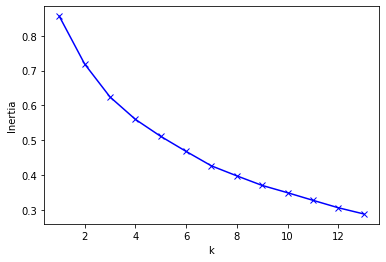

In [37]:
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()

We see that the optimal number of clusters is 3, 4 or 5. After trying with different values, even larger than 5, we decided to choose **--- 5 ---** and the results we obtain are shown below.

In [38]:
# set number of clusters
kclusters = 5

neighborhoods_SF_grouped_clustering = neighborhoods_SF_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(init="k-means++", n_clusters=kclusters, n_init=1000, random_state=0).fit(neighborhoods_SF_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 1, 1, 4, 3, 1, 0, 1, 1], dtype=int32)

Let us create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [39]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

neighborhoods_SF_merged = neighborhoods_SF_coord

neighborhoods_SF_merged = neighborhoods_SF_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

neighborhoods_SF_merged.head() # check the last columns!

Neighborhood   Latitude   Longitude  Cluster Labels  \
0          Seacliff  37.784973 -122.501423               0   
1    Outer Richmond  37.777818 -122.492410               4   
2  Golden Gate Park  37.769383 -122.481940               4   
3      Outer Sunset  37.755419 -122.493805               4   
4          Parkside  37.742096 -122.489641               4   

  1st Most Common Venue  2nd Most Common Venue 3rd Most Common Venue  \
0                 Trail                   Café   Monument / Landmark   
1    Chinese Restaurant                   Café                Bakery   
2                  Park  Vietnamese Restaurant       Bubble Tea Shop   
3    Chinese Restaurant           Liquor Store           Coffee Shop   
4    Chinese Restaurant    Dumpling Restaurant                  Park   

   4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0               Pharmacy              Bus Stop        Scenic Lookout   
1  Vietnamese Restaurant            Playground     Korean Restaurant   
2     Chinese Restaurant                Bakery         Deli / Bodega   
3    Japanese Restaurant    Light Rail Station  Gym / Fitness Center   
4         Sandwich Place              Pharmacy           Supermarket   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0                  Park                 Beach      Sculpture Garden   
1      Sushi Restaurant         Deli / Bodega   Japanese Restaurant   
2   Dumpling Restaurant                Garden           Coffee Shop   
3                  Café        Cosmetics Shop             Pet Store   
4       Thai Restaurant       Bubble Tea Shop        Baseball Field   

  10th Most Common Venue  
0                  Motel  
1          Burrito Place  
2             Playground  
3           Dessert Shop  
4                    Bar

----------

### Clusters re-labelling

In addition, we want to change the number assigned to each cluster in such a way that small numbers are given to the clusters with a high number of elements. This means, for instance, that the number 0 will be assigned to the cluster which has the maximum number of elements. We proceed as follows:

In [40]:
df_new_clusters_names = neighborhoods_SF_merged.groupby('Cluster Labels').count()[['Neighborhood']].sort_values(by='Neighborhood',ascending=False).reset_index().reset_index()
df_new_clusters_names

index  Cluster Labels  Neighborhood
0      0               1            23
1      1               4             7
2      2               0             4
3      3               3             2
4      4               2             1

In [41]:
df_new_clusters_names.rename(columns={'index':'New Cluster Labels'},inplace=True)
df_new_clusters_names.drop(['Neighborhood'],axis=1,inplace=True)

In [42]:
df_new_clusters_names

New Cluster Labels  Cluster Labels
0                   0               1
1                   1               4
2                   2               0
3                   3               3
4                   4               2

In [43]:
neighborhoods_SF_merged = neighborhoods_SF_merged.join(df_new_clusters_names.set_index('Cluster Labels'), on='Cluster Labels', how='left')

neighborhoods_SF_merged.head()

Neighborhood   Latitude   Longitude  Cluster Labels  \
0          Seacliff  37.784973 -122.501423               0   
1    Outer Richmond  37.777818 -122.492410               4   
2  Golden Gate Park  37.769383 -122.481940               4   
3      Outer Sunset  37.755419 -122.493805               4   
4          Parkside  37.742096 -122.489641               4   

  1st Most Common Venue  2nd Most Common Venue 3rd Most Common Venue  \
0                 Trail                   Café   Monument / Landmark   
1    Chinese Restaurant                   Café                Bakery   
2                  Park  Vietnamese Restaurant       Bubble Tea Shop   
3    Chinese Restaurant           Liquor Store           Coffee Shop   
4    Chinese Restaurant    Dumpling Restaurant                  Park   

   4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0               Pharmacy              Bus Stop        Scenic Lookout   
1  Vietnamese Restaurant            Playground     Korean Restaurant   
2     Chinese Restaurant                Bakery         Deli / Bodega   
3    Japanese Restaurant    Light Rail Station  Gym / Fitness Center   
4         Sandwich Place              Pharmacy           Supermarket   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0                  Park                 Beach      Sculpture Garden   
1      Sushi Restaurant         Deli / Bodega   Japanese Restaurant   
2   Dumpling Restaurant                Garden           Coffee Shop   
3                  Café        Cosmetics Shop             Pet Store   
4       Thai Restaurant       Bubble Tea Shop        Baseball Field   

  10th Most Common Venue  New Cluster Labels  
0                  Motel                   2  
1          Burrito Place                   1  
2             Playground                   1  
3           Dessert Shop                   1  
4                    Bar                   1

In [44]:
neighborhoods_SF_merged['Cluster Labels'] = neighborhoods_SF_merged['New Cluster Labels']
neighborhoods_SF_merged.head()

Neighborhood   Latitude   Longitude  Cluster Labels  \
0          Seacliff  37.784973 -122.501423               2   
1    Outer Richmond  37.777818 -122.492410               1   
2  Golden Gate Park  37.769383 -122.481940               1   
3      Outer Sunset  37.755419 -122.493805               1   
4          Parkside  37.742096 -122.489641               1   

  1st Most Common Venue  2nd Most Common Venue 3rd Most Common Venue  \
0                 Trail                   Café   Monument / Landmark   
1    Chinese Restaurant                   Café                Bakery   
2                  Park  Vietnamese Restaurant       Bubble Tea Shop   
3    Chinese Restaurant           Liquor Store           Coffee Shop   
4    Chinese Restaurant    Dumpling Restaurant                  Park   

   4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0               Pharmacy              Bus Stop        Scenic Lookout   
1  Vietnamese Restaurant            Playground     Korean Restaurant   
2     Chinese Restaurant                Bakery         Deli / Bodega   
3    Japanese Restaurant    Light Rail Station  Gym / Fitness Center   
4         Sandwich Place              Pharmacy           Supermarket   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0                  Park                 Beach      Sculpture Garden   
1      Sushi Restaurant         Deli / Bodega   Japanese Restaurant   
2   Dumpling Restaurant                Garden           Coffee Shop   
3                  Café        Cosmetics Shop             Pet Store   
4       Thai Restaurant       Bubble Tea Shop        Baseball Field   

  10th Most Common Venue  New Cluster Labels  
0                  Motel                   2  
1          Burrito Place                   1  
2             Playground                   1  
3           Dessert Shop                   1  
4                    Bar                   1

In [45]:
neighborhoods_SF_merged.drop(['New Cluster Labels'],axis=1,inplace=True)
neighborhoods_SF_merged.head()

Neighborhood   Latitude   Longitude  Cluster Labels  \
0          Seacliff  37.784973 -122.501423               2   
1    Outer Richmond  37.777818 -122.492410               1   
2  Golden Gate Park  37.769383 -122.481940               1   
3      Outer Sunset  37.755419 -122.493805               1   
4          Parkside  37.742096 -122.489641               1   

  1st Most Common Venue  2nd Most Common Venue 3rd Most Common Venue  \
0                 Trail                   Café   Monument / Landmark   
1    Chinese Restaurant                   Café                Bakery   
2                  Park  Vietnamese Restaurant       Bubble Tea Shop   
3    Chinese Restaurant           Liquor Store           Coffee Shop   
4    Chinese Restaurant    Dumpling Restaurant                  Park   

   4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0               Pharmacy              Bus Stop        Scenic Lookout   
1  Vietnamese Restaurant            Playground     Korean Restaurant   
2     Chinese Restaurant                Bakery         Deli / Bodega   
3    Japanese Restaurant    Light Rail Station  Gym / Fitness Center   
4         Sandwich Place              Pharmacy           Supermarket   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0                  Park                 Beach      Sculpture Garden   
1      Sushi Restaurant         Deli / Bodega   Japanese Restaurant   
2   Dumpling Restaurant                Garden           Coffee Shop   
3                  Café        Cosmetics Shop             Pet Store   
4       Thai Restaurant       Bubble Tea Shop        Baseball Field   

  10th Most Common Venue  
0                  Motel  
1          Burrito Place  
2             Playground  
3           Dessert Shop  
4                    Bar

----------

Finally, we can visualize the resulting clusters on the San Francisco map below. Click on the circle markers to see a popup with the name of the neighborhood and the cluster number.

In [46]:
# create map
map_SF_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, neighborhood, cluster in zip(neighborhoods_SF_merged['Latitude'], neighborhoods_SF_merged['Longitude'], neighborhoods_SF_merged['Neighborhood'], neighborhoods_SF_merged['Cluster Labels']):
    label = folium.Popup(str(neighborhood) + ' - ' + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=['black'],
#         color=rainbow[cluster-1],
#         color=['red','orange','green','blue'],
        fill=True,
        fill_color=rainbow[len(rainbow)-1 - cluster],
#         fill_color=['red','orange','green','blue'],
        fill_opacity=1).add_to(map_SF_clusters)
       
map_SF_clusters

We see that the neighborhoods can be grouped into 5 clusters. One of them, __Cluster 0__, has more than half of the neighborhoods namely 23 out of 37. The smallest cluster contains only the neighborhood "Treasure Island". In the next section, we will analyze more in details the content of each cluster.

------------------

## 3.2. Analysis of the Clusters

Now, we can examine each cluster and determine the discriminating venue categories that distinguish each cluster.

## 3.2.1. Top 10 Most Common Venues per Neighborhood per Cluster

### Cluster 0

In [47]:
neighborhoods_SF_merged.loc[neighborhoods_SF_merged['Cluster Labels'] == 0, neighborhoods_SF_merged.columns[[0] + list(range(3, neighborhoods_SF_merged.shape[1]))]]

Neighborhood  Cluster Labels            1st Most Common Venue  \
5             Lakeshore               0                        Juice Bar   
8          Inner Sunset               0                            Trail   
9    West of Twin Peaks               0                      Coffee Shop   
11     Presidio Heights               0                   Cosmetics Shop   
12       Haight-Ashbury               0                             Park   
14        Outer Mission               0               Mexican Restaurant   
16               Marina               0             Gym / Fitness Center   
17      Pacific Heights               0               Italian Restaurant   
18     Western Addition               0                           Bakery   
19  Castro-Upper Market               0                          Gay Bar   
20           Noe Valley               0                             Park   
22            Glen Park               0                             Café   
23         Russian Hill               0                             Park   
24             Nob Hill               0               Italian Restaurant   
25  Downtown-Tenderloin               0                      Coffee Shop   
26              Mission               0                             Café   
27       Bernal Heights               0               Mexican Restaurant   
30          North Beach               0                      Pizza Place   
31            Chinatown               0                      Coffee Shop   
32   Financial District               0                      Coffee Shop   
33      South of Market               0                      Coffee Shop   
34         Potrero Hill               0                      Coffee Shop   
35              Bayview               0  Southern / Soul Food Restaurant   

     2nd Most Common Venue 3rd Most Common Venue    4th Most Common Venue  \
5                     Café           Candy Store                     Park   
8              Coffee Shop                  Park         Sushi Restaurant   
9              Pizza Place          Burger Joint       Mexican Restaurant   
11  Furniture / Home Store    Italian Restaurant              Coffee Shop   
12             Coffee Shop                  Café           Ice Cream Shop   
14             Coffee Shop                  Park           Sandwich Place   
16       French Restaurant              Wine Bar       Italian Restaurant   
17          Cosmetics Shop                Bakery                     Park   
18                Tea Room        Ice Cream Shop                     Park   
19                    Park           Coffee Shop  New American Restaurant   
20                    Café           Coffee Shop                Gift Shop   
22                    Park           Pizza Place           Breakfast Spot   
23      Italian Restaurant        Chocolate Shop                      Bar   
24   Vietnamese Restaurant              Wine Bar              Coffee Shop   
25   Vietnamese Restaurant                Bakery                  Theater   
26      Mexican Restaurant          Cocktail Bar              Coffee Shop   
27             Coffee Shop                  Café               Playground   
30      Seafood Restaurant                  Park              Coffee Shop   
31                   Hotel           Men's Store       Chinese Restaurant   
32                     Gym                  Café               Food Truck   
33             Pizza Place  Gym / Fitness Center  New American Restaurant   
34                    Park           Art Gallery                     Café   
35             Coffee Shop    Mexican Restaurant                   Bakery   

       5th Most Common Venue    6th Most Common Venue  \
5             Cosmetics Shop           Sandwich Place   
8                     Bakery           Ice Cream Shop   
9                   Bus Line               Playground   
11       American Restaurant              Golf Course   
12               Yoga Studio            Grocery Stor

### Cluster 1

In [48]:
neighborhoods_SF_merged.loc[neighborhoods_SF_merged['Cluster Labels'] == 1, neighborhoods_SF_merged.columns[[0] + list(range(3, neighborhoods_SF_merged.shape[1]))]]

Neighborhood  Cluster Labels 1st Most Common Venue  \
1     Outer Richmond               1    Chinese Restaurant   
2   Golden Gate Park               1                  Park   
3       Outer Sunset               1    Chinese Restaurant   
4           Parkside               1    Chinese Restaurant   
7     Inner Richmond               1                Bakery   
10         Oceanview               1           Yoga Studio   
15    Crocker Amazon               1           Pizza Place   

    2nd Most Common Venue 3rd Most Common Venue  4th Most Common Venue  \
1                    Café                Bakery  Vietnamese Restaurant   
2   Vietnamese Restaurant       Bubble Tea Shop     Chinese Restaurant   
3            Liquor Store           Coffee Shop    Japanese Restaurant   
4     Dumpling Restaurant                  Park         Sandwich Place   
7      Chinese Restaurant   Japanese Restaurant                 Garden   
10     Chinese Restaurant      Asian Restaurant            Pizza Place   
15           Liquor Store    Mexican Restaurant         Baseball Field   

   5th Most Common Venue 6th Most Common Venue  7th Most Common Venue  \
1             Playground     Korean Restaurant       Sushi Restaurant   
2                 Bakery         Deli / Bodega    Dumpling Restaurant   
3     Light Rail Station  Gym / Fitness Center                   Café   
4               Pharmacy           Supermarket        Thai Restaurant   
7                   Café     Korean Restaurant        Thai Restaurant   
10   Japanese Restaurant           Coffee Shop          Grocery Store   
15    Chinese Restaurant            Playground  Vietnamese Restaurant   

        8th Most Common Venue  9th Most Common Venue 10th Most Common Venue  
1               Deli / Bodega    Japanese Restaurant          Burrito Place  
2                      Garden            Coffee Shop             Playground  
3              Cosmetics Shop              Pet Store           Dessert Shop  
4             Bubble Tea Shop         Baseball Field                    Bar  
7          Burmese Restaurant  Vietnamese Restaurant       Asian Restaurant  
10                 Poke Place      Convenience Store     Light Rail Station  
15  Latin American Restaurant              Pool Hall           Soccer Field

### Cluster 2

In [49]:
neighborhoods_SF_merged.loc[neighborhoods_SF_merged['Cluster Labels'] == 2, neighborhoods_SF_merged.columns[[0] + list(range(3, neighborhoods_SF_merged.shape[1]))]]

Neighborhood  Cluster Labels 1st Most Common Venue  \
0            Seacliff               2                 Trail   
6            Presidio               2                 Trail   
28          Excelsior               2                  Park   
29  Visitacion Valley               2         Grocery Store   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0                   Café   Monument / Landmark              Pharmacy   
6                   Park                  Café        Scenic Lookout   
28               Dog Run        Baseball Field     Convenience Store   
29                  Park                 Trail                Garden   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0               Bus Stop        Scenic Lookout                  Park   
6                 Tunnel                Museum        Baseball Field   
28                  Farm                 Trail        Scenic Lookout   
29           Bus Station    Chinese Restaurant            Bike Trail   

   8th Most Common Venue  9th Most Common Venue 10th Most Common Venue  
0                  Beach       Sculpture Garden                  Motel  
6             Food Truck  General Entertainment                  Plaza  
28          Liquor Store   Gym / Fitness Center             Playground  
29               Theater                   Café         Baseball Field

### Cluster 3

In [50]:
neighborhoods_SF_merged.loc[neighborhoods_SF_merged['Cluster Labels'] == 3, neighborhoods_SF_merged.columns[[0] + list(range(3, neighborhoods_SF_merged.shape[1]))]]

Neighborhood  Cluster Labels 1st Most Common Venue  \
13       Twin-Peaks               3                 Trail   
21  Diamond Heights               3                  Park   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
13                  Park              Bus Stop        Scenic Lookout   
21                 Trail            Playground           Coffee Shop   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
13    Light Rail Station             Reservoir                  Hill   
21        Scenic Lookout               Theater       Thai Restaurant   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
13           Event Space           Tailor Shop          Grocery Store  
21     Martial Arts Dojo         Grocery Store               Mountain

### Cluster 4

In [51]:
neighborhoods_SF_merged.loc[neighborhoods_SF_merged['Cluster Labels'] == 4, neighborhoods_SF_merged.columns[[0] + list(range(3, neighborhoods_SF_merged.shape[1]))]]

Neighborhood  Cluster Labels 1st Most Common Venue  \
36  Treasure Island               4            Food Truck   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
36    Athletics & Sports       Harbor / Marina        Baseball Field   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
36           Music Venue                 Beach                  Park   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
36   Fried Chicken Joint         Grocery Store         History Museum

--------

### Discussion

From this first analysis, we can say that __Cluster 0__, the largest, is rather miscellaneous, the dominant categories seem "Coffee shop" and "Café". On the othere hand, __Cluster 1__ contains mainly those neighborhoods where is likely to find a Chinese Restaurant. __Cluster 2__ and __Cluster 3__ are similar and characterized by trails and parks. Finally, __Cluster 4__ has only "Treasure Island" as neighborhood which has venues mostly in the "Food Truck" category as well as venues related to sport and music events.

------------

## 3.2.2. Total Venues per Category per Cluster

In order to have a better understanding of the most common venues in each cluster, we consider here the total number of venues grouped per category in each cluster. This analysis will help us to decide the name/label to give to a cluster.

We start from the dataframe *neighborhoods_SF_onehot* containing the One Hot Encoding, then we group by clusters and sum over the categories as follows.

In [52]:
neighborhoods_SF_onehot.head()

Zoo Exhibit  ATM  Acai House  Accessories Store  Adult Boutique  \
0            0    0           0                  0               0   
1            0    0           0                  0               0   
2            0    0           0                  0               0   
3            0    0           0                  0               0   
4            0    0           0                  0               0   

   African Restaurant  Alternative Healer  American Restaurant  Antique Shop  \
0                   0                   0                    0             0   
1                   0                   0                    0             0   
2                   0                   0                    0             0   
3                   0                   0                    0             0   
4                   0                   0                    0             0   

   Arcade  Argentinian Restaurant  Art Gallery  Art Museum  \
0       0                       0            0           1   
1       0                       0            0           0   
2       0                       0            0           0   
3       0                       0            0           0   
4       0                       0            0           0   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  Automotive Shop  \
0                    0                 0                   0                0   
1                    0                 0                   0                0   
2                    0                 0                   0                0   
3                    0                 0                   0                0   
4                    0                 0                   0                0   

   BBQ Joint  Baby Store  Bagel Shop  Bakery  Bank  Bar  Baseball Field  \
0          0           0           0       0     0    0               0   
1          0           0           0       0     0    0               0   
2          0           0           0       0     0    0               0   
3          0           0           0       0     0    0               0   
4          0           0           0       0     0    0               0   

   Baseball Stadium  Basketball Court  Bath House  Beach  Bed & Breakfast  \
0                 0                 0           0      0                0   
1                 0                 0           0      0                0   
2                 0                 0           0      1                0   
3                 0                 0           0      0                0   
4                 0                 0           0      0                0   

   Beer Bar  Beer Garden  Beer Store  Big Box Store  Bike Rental / Bike Share  \
0         0            0           0              0                         0   
1         0            0           0              0                         0   
2         0            0           0              0                         0   
3         0            0           0              0                         0   
4         0            0           0              0                         0   

   Bike Shop  Bike Trail  Bistro  Board Shop  Bookstore  Botanical Garden  \
0          0           0       0           0          0                 0   
1          0           0       0           0          0                 0   
2          0           0       0           0          0                 0   
3          0           0       0           0          0                 0   
4          0           0       0           0          0                 0   

   Boutique  Bowling Alley  Bowling Green  Boxing Gym  Brazilian Restaurant  \
0         0              0              0           0                     0   
1         0              0              0           0                     0   
2         0              0              0           0                     0   
3         0              0              0           0        

In [53]:
neighborhoods_SF_onehot.shape

(2971, 326)

In [54]:
neighborhoods_SF_onehot_tot = neighborhoods_SF_onehot.groupby('Neighborhood').sum()
neighborhoods_SF_onehot_tot.head()

Zoo Exhibit  ATM  Acai House  Accessories Store  \
Neighborhood                                                           
Bayview                        0    0           0                  0   
Bernal Heights                 0    0           0                  0   
Castro-Upper Market            0    0           0                  0   
Chinatown                      0    0           0                  0   
Crocker Amazon                 0    0           0                  0   

                     Adult Boutique  African Restaurant  Alternative Healer  \
Neighborhood                                                                  
Bayview                           0                   1                   0   
Bernal Heights                    0                   0                   0   
Castro-Upper Market               0                   0                   0   
Chinatown                         0                   0                   0   
Crocker Amazon                    0                   0                   0   

                     American Restaurant  Antique Shop  Arcade  \
Neighborhood                                                     
Bayview                                0             0       0   
Bernal Heights                         1             0       0   
Castro-Upper Market                    1             0       1   
Chinatown                              1             0       0   
Crocker Amazon                         1             0       0   

                     Argentinian Restaurant  Art Gallery  Art Museum  \
Neighborhood                                                           
Bayview                                   0            0           0   
Bernal Heights                            0            1           0   
Castro-Upper Market                       0            0           0   
Chinatown                                 0            0           0   
Crocker Amazon                            0            0           0   

                     Arts & Crafts Store  Asian Restaurant  \
Neighborhood                                                 
Bayview                                0                 0   
Bernal Heights                         0                 1   
Castro-Upper Market                    1                 0   
Chinatown                              1                 1   
Crocker Amazon                         0                 1   

                     Athletics & Sports  Automotive Shop  BBQ Joint  \
Neighborhood                                                          
Bayview                               0                0          0   
Bernal Heights                        0                0          1   
Castro-Upper Market                   0                0          0   
Chinatown                             0                0          0   
Crocker Amazon                        0                0          0   

                     Baby Store  Bagel Shop  Bakery  Bank  Bar  \
Neighborhood                                                     
Bayview                       0           0       3     0    0   
Bernal Heights                0           0       2     0    0   
Castro-Upper Market           0           0       2     0    0   
Chinatown                     0           0       2     0    2   
Crocker Amazon                0           0       1     0    1   

                     Baseball Field  Baseball Stadium  Basketball Court  \
Neighborhood                                                              
Bayview                           0                 0                 0   
Bernal Heights                    0                 0                 0   
Castro-Upper Market               0                 0                 0   
Chinatown                         0                 0                 0   
Crocker Amazon                    3                 0                 1   

                     Bath House  Beach  Bed & Breakfast  Beer Bar  \
Nei

In [55]:
neighborhoods_SF_onehot_tot.shape

(37, 325)

In [56]:
neighborhoods_SF_onehot_tot.reset_index(inplace=True)
neighborhoods_SF_onehot_tot.shape

(37, 326)

In [57]:
neighborhoods_SF_merged.head()

Neighborhood   Latitude   Longitude  Cluster Labels  \
0          Seacliff  37.784973 -122.501423               2   
1    Outer Richmond  37.777818 -122.492410               1   
2  Golden Gate Park  37.769383 -122.481940               1   
3      Outer Sunset  37.755419 -122.493805               1   
4          Parkside  37.742096 -122.489641               1   

  1st Most Common Venue  2nd Most Common Venue 3rd Most Common Venue  \
0                 Trail                   Café   Monument / Landmark   
1    Chinese Restaurant                   Café                Bakery   
2                  Park  Vietnamese Restaurant       Bubble Tea Shop   
3    Chinese Restaurant           Liquor Store           Coffee Shop   
4    Chinese Restaurant    Dumpling Restaurant                  Park   

   4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0               Pharmacy              Bus Stop        Scenic Lookout   
1  Vietnamese Restaurant            Playground     Korean Restaurant   
2     Chinese Restaurant                Bakery         Deli / Bodega   
3    Japanese Restaurant    Light Rail Station  Gym / Fitness Center   
4         Sandwich Place              Pharmacy           Supermarket   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0                  Park                 Beach      Sculpture Garden   
1      Sushi Restaurant         Deli / Bodega   Japanese Restaurant   
2   Dumpling Restaurant                Garden           Coffee Shop   
3                  Café        Cosmetics Shop             Pet Store   
4       Thai Restaurant       Bubble Tea Shop        Baseball Field   

  10th Most Common Venue  
0                  Motel  
1          Burrito Place  
2             Playground  
3           Dessert Shop  
4                    Bar

In [58]:
neighborhoods_SF_merged.shape

(37, 14)

In [59]:
neighborhoods_SF_merged_clusters = neighborhoods_SF_merged[['Neighborhood','Cluster Labels']]
neighborhoods_SF_merged_clusters.head()

Neighborhood  Cluster Labels
0          Seacliff               2
1    Outer Richmond               1
2  Golden Gate Park               1
3      Outer Sunset               1
4          Parkside               1

In [60]:
neighborhoods_SF_merged_tot_clusters = neighborhoods_SF_merged_clusters.join(neighborhoods_SF_onehot_tot.set_index('Neighborhood'), on='Neighborhood', how='left')

neighborhoods_SF_merged_tot_clusters.head()

Neighborhood  Cluster Labels  Zoo Exhibit  ATM  Acai House  \
0          Seacliff               2            0    0           0   
1    Outer Richmond               1            0    0           0   
2  Golden Gate Park               1            0    0           0   
3      Outer Sunset               1            0    0           0   
4          Parkside               1            0    0           0   

   Accessories Store  Adult Boutique  African Restaurant  Alternative Healer  \
0                  0               0                   0                   0   
1                  0               0                   0                   0   
2                  0               0                   0                   0   
3                  0               0                   0                   0   
4                  0               0                   0                   0   

   American Restaurant  Antique Shop  Arcade  Argentinian Restaurant  \
0                    1             0       0                       0   
1                    1             1       0                       0   
2                    0             0       0                       0   
3                    0             0       0                       0   
4                    1             0       0                       0   

   Art Gallery  Art Museum  Arts & Crafts Store  Asian Restaurant  \
0            0           1                    0                 0   
1            0           0                    0                 0   
2            0           0                    0                 1   
3            0           0                    0                 0   
4            0           0                    0                 1   

   Athletics & Sports  Automotive Shop  BBQ Joint  Baby Store  Bagel Shop  \
0                   0                0          0           0           0   
1                   0                1          1           0           0   
2                   0                0          1           0           0   
3                   0                0          0           0           0   
4                   0                0          0           0           0   

   Bakery  Bank  Bar  Baseball Field  Baseball Stadium  Basketball Court  \
0       0     0    0               0                 0                 0   
1       4     0    0               0                 0                 0   
2       4     2    2               0                 0                 0   
3       1     1    1               1                 0                 0   
4       1     1    2               2                 0                 0   

   Bath House  Beach  Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  \
0           0      2                0         0            0           0   
1           0      0                0         0            0           0   
2           0      0                0         0            0           0   
3           0      0                0         1            0           0   
4           0      0                0         0            0           0   

   Big Box Store  Bike Rental / Bike Share  Bike Shop  Bike Trail  Bistro  \
0              0                         0          0           0       0   
1              0                         0          0           0       0   
2              0                         0          0           0       0   
3              0                         0          0           0       0   
4              0                         0          0           0       0   

   Board Shop  Bookstore  Botanical Garden  Boutique  Bowling Alley  \
0           0          0                 0         0              0   
1           1          0                 0         0              0   
2           0          0                 0         0              0   
3           0          0                 0         1              0   
4           0          0                 0         0              0 

In [61]:
neighborhoods_SF_merged_tot_clusters.shape

(37, 327)

In [62]:
neighborhoods_SF_merged_tot_clusters_only = neighborhoods_SF_merged_tot_clusters.drop(['Neighborhood'],axis=1)
neighborhoods_SF_merged_tot_clusters_only.head()

Cluster Labels  Zoo Exhibit  ATM  Acai House  Accessories Store  \
0               2            0    0           0                  0   
1               1            0    0           0                  0   
2               1            0    0           0                  0   
3               1            0    0           0                  0   
4               1            0    0           0                  0   

   Adult Boutique  African Restaurant  Alternative Healer  \
0               0                   0                   0   
1               0                   0                   0   
2               0                   0                   0   
3               0                   0                   0   
4               0                   0                   0   

   American Restaurant  Antique Shop  Arcade  Argentinian Restaurant  \
0                    1             0       0                       0   
1                    1             1       0                       0   
2                    0             0       0                       0   
3                    0             0       0                       0   
4                    1             0       0                       0   

   Art Gallery  Art Museum  Arts & Crafts Store  Asian Restaurant  \
0            0           1                    0                 0   
1            0           0                    0                 0   
2            0           0                    0                 1   
3            0           0                    0                 0   
4            0           0                    0                 1   

   Athletics & Sports  Automotive Shop  BBQ Joint  Baby Store  Bagel Shop  \
0                   0                0          0           0           0   
1                   0                1          1           0           0   
2                   0                0          1           0           0   
3                   0                0          0           0           0   
4                   0                0          0           0           0   

   Bakery  Bank  Bar  Baseball Field  Baseball Stadium  Basketball Court  \
0       0     0    0               0                 0                 0   
1       4     0    0               0                 0                 0   
2       4     2    2               0                 0                 0   
3       1     1    1               1                 0                 0   
4       1     1    2               2                 0                 0   

   Bath House  Beach  Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  \
0           0      2                0         0            0           0   
1           0      0                0         0            0           0   
2           0      0                0         0            0           0   
3           0      0                0         1            0           0   
4           0      0                0         0            0           0   

   Big Box Store  Bike Rental / Bike Share  Bike Shop  Bike Trail  Bistro  \
0              0                         0          0           0       0   
1              0                         0          0           0       0   
2              0                         0          0           0       0   
3              0                         0          0           0       0   
4              0                         0          0           0       0   

   Board Shop  Bookstore  Botanical Garden  Boutique  Bowling Alley  \
0           0          0                 0         0              0   
1           1          0                 0         0              0   
2           0          0                 0         0              0   
3           0          0                 0         1              0   
4           0          0                 0         0              0   

   Bowling Green  Boxing Gym  Brazilian Restaurant  Breakfast Spot  Brewery  \
0              0     

In [63]:
neighborhoods_SF_merged_tot_clusters_only.shape

(37, 326)

In [64]:
neighborhoods_SF_merged_tot_clusters_only_grouped = neighborhoods_SF_merged_tot_clusters_only.groupby('Cluster Labels').sum()
neighborhoods_SF_merged_tot_clusters_only_grouped.head()

Zoo Exhibit  ATM  Acai House  Accessories Store  \
Cluster Labels                                                    
0                         1    1           1                 10   
1                         0    0           0                  0   
2                         0    0           0                  0   
3                         0    0           0                  0   
4                         0    0           0                  0   

                Adult Boutique  African Restaurant  Alternative Healer  \
Cluster Labels                                                           
0                            1                   1                   3   
1                            0                   0                   0   
2                            0                   0                   0   
3                            0                   0                   0   
4                            0                   0                   0   

                American Restaurant  Antique Shop  Arcade  \
Cluster Labels                                              
0                                20             2       2   
1                                 4             1       0   
2                                 2             0       0   
3                                 1             0       0   
4                                 1             0       0   

                Argentinian Restaurant  Art Gallery  Art Museum  \
Cluster Labels                                                    
0                                    3           22           7   
1                                    0            1           1   
2                                    0            2           1   
3                                    0            1           0   
4                                    0            0           0   

                Arts & Crafts Store  Asian Restaurant  Athletics & Sports  \
Cluster Labels                                                              
0                                14                 9                   1   
1                                 0                10                   0   
2                                 0                 1                   0   
3                                 0                 0                   1   
4                                 0                 0                   3   

                Automotive Shop  BBQ Joint  Baby Store  Bagel Shop  Bakery  \
Cluster Labels                                                               
0                             0          3           1           1      57   
1                             1          4           0           0      18   
2                             1          0           0           0       0   
3                             0          0           0           0       0   
4                             0          0           0           0       0   

                Bank  Bar  Baseball Field  Baseball Stadium  Basketball Court  \
Cluster Labels                                                                  
0                  5   23               4                 1                 1   
1                  6    7               6                 0                 1   
2                  0    0               5                 0                 0   
3                  0    0               1                 0                 0   
4                  0    0               2                 0                 0   

                Bath House  Beach  Bed & Breakfast  Beer Bar  Beer Garden  \
Cluster Labels                                                              
0                        1      1                1         7            1   
1                        0      0                0         2            0   
2                        0      3                1         0            0   
3                        0      0                0         0            0   
4           

In [65]:
neighborhoods_SF_merged_tot_clusters_only_grouped.reset_index(inplace=True, drop=True)

------------

### Cluster 0 - Coffee Shops + Café = Coffee Places

In [66]:
neighborhoods_SF_merged_tot_clusters_only_grouped[0:1].sort_values(by=0,ascending=False,axis=1).T.head(10)

0
Coffee Shop         117
Park                 75
Café                 67
Bakery               57
Pizza Place          54
Italian Restaurant   50
Mexican Restaurant   42
Sandwich Place       37
Sushi Restaurant     36
Wine Bar             35

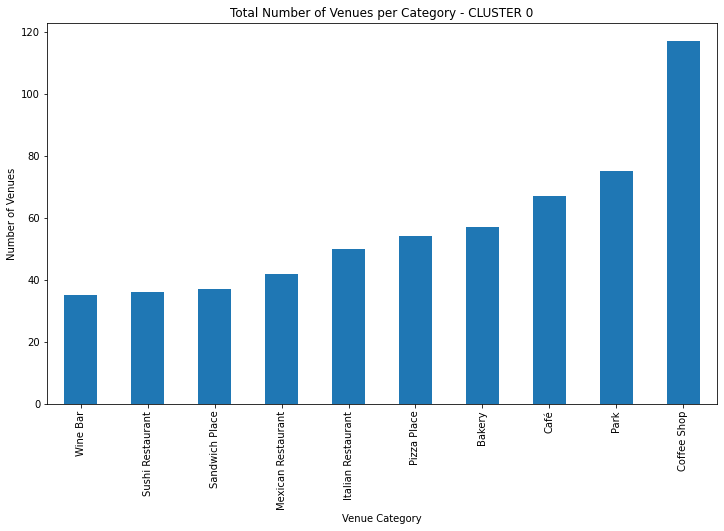

In [67]:
neighborhoods_SF_merged_tot_clusters_only_grouped[0:1].sort_values(by=0,ascending=True,axis=1).T.tail(10).plot(kind='bar', figsize=(12, 7))

plt.xlabel('Venue Category') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Total Number of Venues per Category - CLUSTER 0') # add title to the plot
plt.legend('',frameon=False)

plt.show()

### Cluster 1 - Chinese Restaurants and Asian Cuisine (Vietnamese+Japanese+Korean)

In [68]:
neighborhoods_SF_merged_tot_clusters_only_grouped[1:2].sort_values(by=1,ascending=False,axis=1).T.head(10)

1
Chinese Restaurant     42
Bakery                 18
Park                   17
Vietnamese Restaurant  17
Café                   17
Japanese Restaurant    16
Playground             15
Coffee Shop            15
Korean Restaurant      13
Liquor Store           13

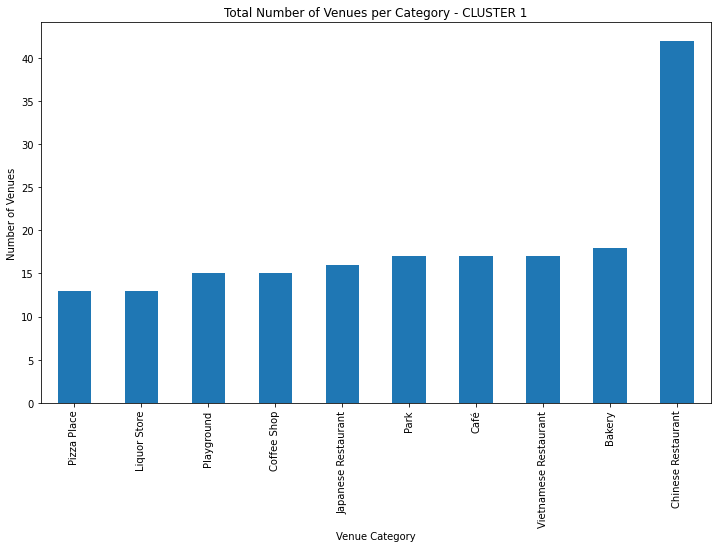

In [69]:
neighborhoods_SF_merged_tot_clusters_only_grouped[1:2].sort_values(by=1,ascending=True,axis=1).T.tail(10).plot(kind='bar', figsize=(12, 7))

plt.xlabel('Venue Category') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Total Number of Venues per Category - CLUSTER 1') # add title to the plot
plt.legend('',frameon=False)

plt.show()

### Cluster 2 - Trails, Parks, and Café

In [70]:
neighborhoods_SF_merged_tot_clusters_only_grouped[2:3].sort_values(by=2,ascending=False,axis=1).T.head(10)

2
Trail              13
Park               10
Café                8
Scenic Lookout      6
Baseball Field      5
Convenience Store   4
Dog Run             3
Pharmacy            3
Beach               3
Tunnel              3

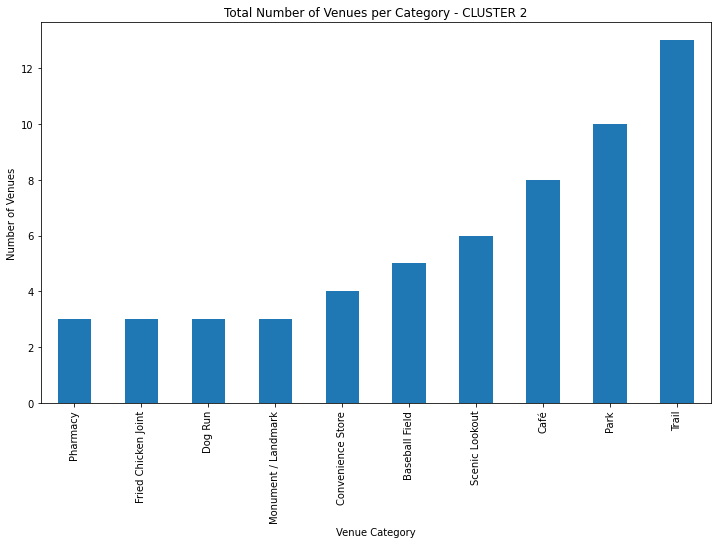

In [71]:
neighborhoods_SF_merged_tot_clusters_only_grouped[2:3].sort_values(by=2,ascending=True,axis=1).T.tail(10).plot(kind='bar', figsize=(12, 7))

plt.xlabel('Venue Category') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Total Number of Venues per Category - CLUSTER 2') # add title to the plot
plt.legend('',frameon=False)

plt.show()

### Cluster 3 - Trails and Parks

In [72]:
neighborhoods_SF_merged_tot_clusters_only_grouped[3:4].sort_values(by=3,ascending=False,axis=1).T.head(10)

3
Trail           18
Park            17
Playground       5
Scenic Lookout   4
Bus Stop         4
Coffee Shop      3
Theater          2
Pharmacy         2
Mountain         2
Grocery Store    2

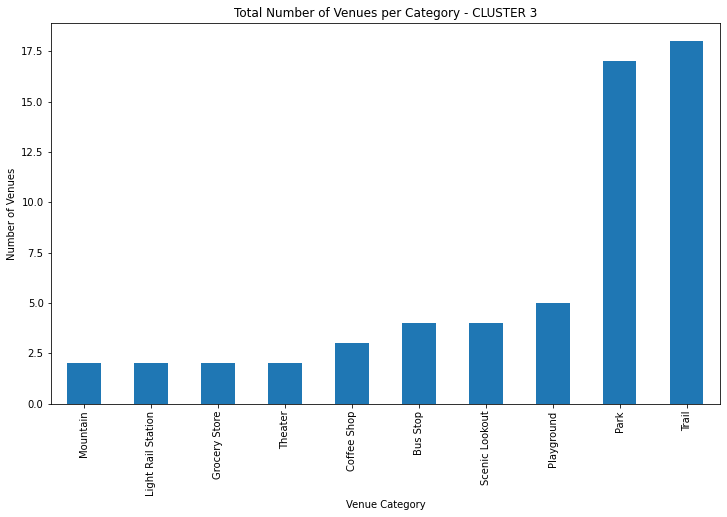

In [73]:
neighborhoods_SF_merged_tot_clusters_only_grouped[3:4].sort_values(by=3,ascending=True,axis=1).T.tail(10).plot(kind='bar', figsize=(12, 7))

plt.xlabel('Venue Category') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Total Number of Venues per Category - CLUSTER 3') # add title to the plot
plt.legend('',frameon=False)

plt.show()

### Cluster 4 - Food Trucks, Sport and Music Events Places

In [74]:
neighborhoods_SF_merged_tot_clusters_only_grouped[4:5].sort_values(by=4,ascending=False,axis=1).T.head(10)

4
Food Truck          7
Athletics & Sports  3
Harbor / Marina     2
Baseball Field      2
Music Venue         2
Rugby Pitch         1
Beach               1
Flea Market         1
History Museum      1
Food Stand          1

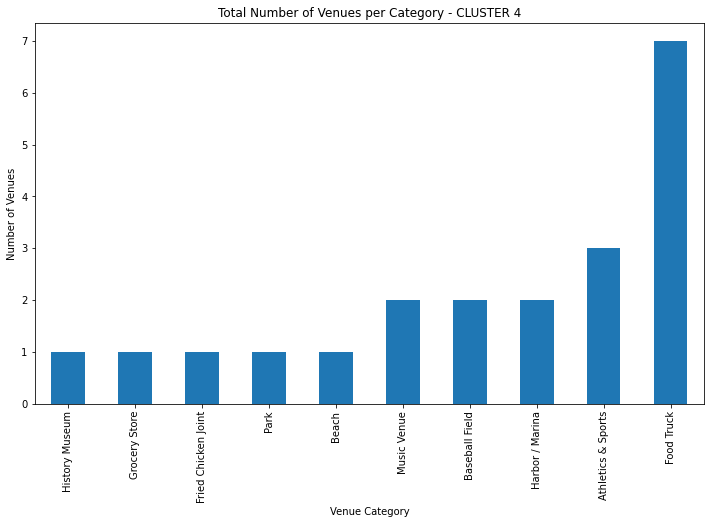

In [75]:
neighborhoods_SF_merged_tot_clusters_only_grouped[4:5].sort_values(by=4,ascending=True,axis=1).T.tail(10).plot(kind='bar', figsize=(12, 7))

plt.xlabel('Venue Category') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Total Number of Venues per Category - CLUSTER 4') # add title to the plot
plt.legend('',frameon=False)

plt.show()

------------

### Discussion

Thanks to the analysis of the most common venues carried out above, we label the 5 clusters as follows:

- Cluster 0 - Coffee Places (Miscellaneous)
- Cluster 1 - Chinese Restaurants and Asian Cuisine (Vietnamese+Japanese+Korean)
- Cluster 2 - Trails, Parks, and Café
- Cluster 3 - Trails and Parks
- Cluster 4 - Food Trucks, Sport and Music Events Places

We notice first of all that the clusters 2 and 3 could be considered as one cluster whose label would be "Trails and Parks". Further analysis is required to understand the reason why the _k-means_ method differentiate them, but this is out of the scope of this project.

On the other hand, since __Cluster 0__ is large and rather miscellaneous (even if it contains mainly coffee places), we decided to clusterize it separately. In this way, we can achieve a better understanding of the venues that it contains. This sub-clustering is described in the next section.

--------------------

<a id='item4'></a>

## 4. Sub-Clustering

Since one of the clusters obtained in the previous section contains most of the neighborhoods of San Francisco and given that this "problem" is not solved by simply increasing the number of clusters, we decided to further apply the _k_-means clustering method to the "large" cluster only.

## 4.1. Selection of the "Large" Cluster

The dataframe containing the list of neighborhoods with the frequency of occurrence of each venues category is

In [76]:
neighborhoods_SF_grouped.head()

Neighborhood  Zoo Exhibit  ATM  Acai House  Accessories Store  \
0              Bayview          0.0  0.0         0.0                0.0   
1       Bernal Heights          0.0  0.0         0.0                0.0   
2  Castro-Upper Market          0.0  0.0         0.0                0.0   
3            Chinatown          0.0  0.0         0.0                0.0   
4       Crocker Amazon          0.0  0.0         0.0                0.0   

   Adult Boutique  African Restaurant  Alternative Healer  \
0             0.0            0.022222                 0.0   
1             0.0            0.000000                 0.0   
2             0.0            0.000000                 0.0   
3             0.0            0.000000                 0.0   
4             0.0            0.000000                 0.0   

   American Restaurant  Antique Shop  Arcade  Argentinian Restaurant  \
0             0.000000           0.0    0.00                     0.0   
1             0.010000           0.0    0.00                     0.0   
2             0.010000           0.0    0.01                     0.0   
3             0.010000           0.0    0.00                     0.0   
4             0.020408           0.0    0.00                     0.0   

   Art Gallery  Art Museum  Arts & Crafts Store  Asian Restaurant  \
0         0.00         0.0                 0.00          0.000000   
1         0.01         0.0                 0.00          0.010000   
2         0.00         0.0                 0.01          0.000000   
3         0.00         0.0                 0.01          0.010000   
4         0.00         0.0                 0.00          0.020408   

   Athletics & Sports  Automotive Shop  BBQ Joint  Baby Store  Bagel Shop  \
0                 0.0              0.0       0.00         0.0         0.0   
1                 0.0              0.0       0.01         0.0         0.0   
2                 0.0              0.0       0.00         0.0         0.0   
3                 0.0              0.0       0.00         0.0         0.0   
4                 0.0              0.0       0.00         0.0         0.0   

     Bakery  Bank       Bar  Baseball Field  Baseball Stadium  \
0  0.066667   0.0  0.000000        0.000000               0.0   
1  0.020000   0.0  0.000000        0.000000               0.0   
2  0.020000   0.0  0.000000        0.000000               0.0   
3  0.020000   0.0  0.020000        0.000000               0.0   
4  0.020408   0.0  0.020408        0.061224               0.0   

   Basketball Court  Bath House  Beach  Bed & Breakfast  Beer Bar  \
0          0.000000         0.0    0.0              0.0      0.00   
1          0.000000         0.0    0.0              0.0      0.01   
2          0.000000         0.0    0.0              0.0      0.00   
3          0.000000         0.0    0.0              0.0      0.00   
4          0.020408         0.0    0.0              0.0      0.00   

   Beer Garden  Beer Store  Big Box Store  Bike Rental / Bike Share  \
0          0.0         0.0            0.0                       0.0   
1          0.0         0.0            0.0                       0.0   
2          0.0         0.0            0.0                       0.0   
3          0.0         0.0            0.0                       0.0   
4          0.0         0.0            0.0                       0.0   

   Bike Shop  Bike Trail  Bistro  Board Shop  Bookstore  Botanical Garden  \
0        0.0         0.0     0.0         0.0       0.00               0.0   
1        0.0         0.0     0.0         0.0       0.00               0.0   
2        0.0         0.0     0.0         0.0       0.01               0.0   
3        0.0         0.0     0.0         0.0       0.02               0.0   
4        0.0         0.0     0.0         0.0       0.00               0.0   

   Boutique  Bowling Alley  Bowling Green  Boxing Gym  Brazilian Restaurant  \
0      0.00            0.0       0.000000         0.0                   0.0   
1      0.00            0.0 

In [77]:
neighborhoods_SF_grouped.shape

(37, 326)

We define a list that will contain the number of elements in each cluster found in the previous section as

In [78]:
cluster_elements_numb = []

for cluster_iii in range(0, kclusters):
    elements = neighborhoods_SF_merged.loc[neighborhoods_SF_merged['Cluster Labels'] == cluster_iii, neighborhoods_SF_merged.columns[[0] + list(range(3, neighborhoods_SF_merged.shape[1]))]].shape[0]
    cluster_elements_numb.append(elements)
    
cluster_elements_numb

[23, 7, 4, 2, 1]

In [79]:
print('The cluster {} has the maximum number of elements equal to {}'.format(cluster_elements_numb.index(max(cluster_elements_numb)),max(cluster_elements_numb)))

The cluster 0 has the maximum number of elements equal to 23


We store the number of the "large" cluster into a new variable

In [80]:
cluster_max_elements = cluster_elements_numb.index(max(cluster_elements_numb))
cluster_max_elements

0

and use it to focus on that cluster only:

In [81]:
neighborhoods_SF_selected_cluster = neighborhoods_SF_merged.loc[neighborhoods_SF_merged['Cluster Labels'] == cluster_max_elements, neighborhoods_SF_merged.columns[[0]]]
neighborhoods_SF_selected_cluster.head()

Neighborhood
5            Lakeshore
8         Inner Sunset
9   West of Twin Peaks
11    Presidio Heights
12      Haight-Ashbury

In [82]:
neighborhoods_SF_selected_cluster.loc[:,'Neighborhood']

5               Lakeshore
8            Inner Sunset
9      West of Twin Peaks
11       Presidio Heights
12         Haight-Ashbury
14          Outer Mission
16                 Marina
17        Pacific Heights
18       Western Addition
19    Castro-Upper Market
20             Noe Valley
22              Glen Park
23           Russian Hill
24               Nob Hill
25    Downtown-Tenderloin
26                Mission
27         Bernal Heights
30            North Beach
31              Chinatown
32     Financial District
33        South of Market
34           Potrero Hill
35                Bayview
Name: Neighborhood, dtype: object

In [83]:
neighborhoods_SF_selected_cluster_list = neighborhoods_SF_selected_cluster['Neighborhood'].to_list()
neighborhoods_SF_selected_cluster_list

['Lakeshore',
 'Inner Sunset',
 'West of Twin Peaks',
 'Presidio Heights',
 'Haight-Ashbury',
 'Outer Mission',
 'Marina',
 'Pacific Heights',
 'Western Addition',
 'Castro-Upper Market',
 'Noe Valley',
 'Glen Park',
 'Russian Hill',
 'Nob Hill',
 'Downtown-Tenderloin',
 'Mission',
 'Bernal Heights',
 'North Beach',
 'Chinatown',
 'Financial District',
 'South of Market',
 'Potrero Hill',
 'Bayview']

The dataframe containing the list of neighborhoods of the selected "large" cluster with the frequency of occurrence of each venues category is

In [84]:
neighborhoods_SF_grouped_2 = neighborhoods_SF_grouped[neighborhoods_SF_grouped['Neighborhood'].isin(neighborhoods_SF_selected_cluster_list)]
neighborhoods_SF_grouped_2

Neighborhood  Zoo Exhibit   ATM  Acai House  Accessories Store  \
0               Bayview         0.00  0.00        0.00           0.000000   
1        Bernal Heights         0.00  0.00        0.00           0.000000   
2   Castro-Upper Market         0.00  0.00        0.00           0.000000   
3             Chinatown         0.00  0.00        0.00           0.000000   
6   Downtown-Tenderloin         0.00  0.00        0.00           0.000000   
8    Financial District         0.00  0.00        0.01           0.000000   
9             Glen Park         0.00  0.00        0.00           0.000000   
11       Haight-Ashbury         0.00  0.00        0.00           0.020000   
13         Inner Sunset         0.00  0.00        0.00           0.000000   
14            Lakeshore         0.00  0.00        0.00           0.018182   
15               Marina         0.00  0.00        0.00           0.010000   
16              Mission         0.00  0.00        0.00           0.010000   
17             Nob Hill         0.00  0.00        0.00           0.000000   
18           Noe Valley         0.00  0.00        0.00           0.000000   
19          North Beach         0.01  0.00        0.00           0.010000   
21        Outer Mission         0.00  0.00        0.00           0.000000   
24      Pacific Heights         0.00  0.00        0.00           0.010000   
26         Potrero Hill         0.00  0.00        0.00           0.010000   
28     Presidio Heights         0.00  0.01        0.00           0.010000   
29         Russian Hill         0.00  0.00        0.00           0.000000   
31      South of Market         0.00  0.00        0.00           0.010000   
35   West of Twin Peaks         0.00  0.00        0.00           0.000000   
36     Western Addition         0.00  0.00        0.00           0.000000   

    Adult Boutique  African Restaurant  Alternative Healer  \
0             0.00            0.022222            0.000000   
1             0.00            0.000000            0.000000   
2             0.00            0.000000            0.000000   
3             0.00            0.000000            0.000000   
6             0.00            0.000000            0.000000   
8             0.00            0.000000            0.010000   
9             0.00            0.000000            0.016129   
11            0.00            0.000000            0.000000   
13            0.00            0.000000            0.000000   
14            0.00            0.000000            0.000000   
15            0.00            0.000000            0.010000   
16            0.01            0.000000            0.000000   
17            0.00            0.000000            0.000000   
18            0.00            0.000000            0.000000   
19            0.00            0.000000            0.000000   
21            0.00            0.000000            0.000000   
24            0.00            0.000000            0.000000   
26            0.00            0.000000            0.000000   
28            0.00            0.000000            0.000000   
29            0.00            0.000000            0.000000   
31            0.00            0.000000            0.000000   
35            0.00            0.000000            0.000000   
36            0.00            0.000000            0.000000   

    American Restaurant  Antique Shop  Arcade  Argentinian Restaurant  \
0              0.000000          0.00    0.00                    0.00   
1              0.010000          0.00    0.00                    0.00   
2              0.010000          0.00    0.01                    0.00   
3              0.010000          0.00    0.00                    0.00   
6              0.000000          0.00    0.00                    0.00   
8              0.000000          0.00    0.00                    0.00   
9              0.000000          0.00    0.00                    0.00   
11             0.000000          0.00    0.01                    0.00   
13             0

In [85]:
neighborhoods_SF_grouped_2.shape

(23, 326)

In [86]:
neighborhoods_SF_grouped_2.reset_index(inplace=True)

In [87]:
neighborhoods_SF_grouped_2.drop('index', 1, inplace=True)

/Users/Angelo/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [88]:
neighborhoods_SF_grouped_2

Neighborhood  Zoo Exhibit   ATM  Acai House  Accessories Store  \
0               Bayview         0.00  0.00        0.00           0.000000   
1        Bernal Heights         0.00  0.00        0.00           0.000000   
2   Castro-Upper Market         0.00  0.00        0.00           0.000000   
3             Chinatown         0.00  0.00        0.00           0.000000   
4   Downtown-Tenderloin         0.00  0.00        0.00           0.000000   
5    Financial District         0.00  0.00        0.01           0.000000   
6             Glen Park         0.00  0.00        0.00           0.000000   
7        Haight-Ashbury         0.00  0.00        0.00           0.020000   
8          Inner Sunset         0.00  0.00        0.00           0.000000   
9             Lakeshore         0.00  0.00        0.00           0.018182   
10               Marina         0.00  0.00        0.00           0.010000   
11              Mission         0.00  0.00        0.00           0.010000   
12             Nob Hill         0.00  0.00        0.00           0.000000   
13           Noe Valley         0.00  0.00        0.00           0.000000   
14          North Beach         0.01  0.00        0.00           0.010000   
15        Outer Mission         0.00  0.00        0.00           0.000000   
16      Pacific Heights         0.00  0.00        0.00           0.010000   
17         Potrero Hill         0.00  0.00        0.00           0.010000   
18     Presidio Heights         0.00  0.01        0.00           0.010000   
19         Russian Hill         0.00  0.00        0.00           0.000000   
20      South of Market         0.00  0.00        0.00           0.010000   
21   West of Twin Peaks         0.00  0.00        0.00           0.000000   
22     Western Addition         0.00  0.00        0.00           0.000000   

    Adult Boutique  African Restaurant  Alternative Healer  \
0             0.00            0.022222            0.000000   
1             0.00            0.000000            0.000000   
2             0.00            0.000000            0.000000   
3             0.00            0.000000            0.000000   
4             0.00            0.000000            0.000000   
5             0.00            0.000000            0.010000   
6             0.00            0.000000            0.016129   
7             0.00            0.000000            0.000000   
8             0.00            0.000000            0.000000   
9             0.00            0.000000            0.000000   
10            0.00            0.000000            0.010000   
11            0.01            0.000000            0.000000   
12            0.00            0.000000            0.000000   
13            0.00            0.000000            0.000000   
14            0.00            0.000000            0.000000   
15            0.00            0.000000            0.000000   
16            0.00            0.000000            0.000000   
17            0.00            0.000000            0.000000   
18            0.00            0.000000            0.000000   
19            0.00            0.000000            0.000000   
20            0.00            0.000000            0.000000   
21            0.00            0.000000            0.000000   
22            0.00            0.000000            0.000000   

    American Restaurant  Antique Shop  Arcade  Argentinian Restaurant  \
0              0.000000          0.00    0.00                    0.00   
1              0.010000          0.00    0.00                    0.00   
2              0.010000          0.00    0.01                    0.00   
3              0.010000          0.00    0.00                    0.00   
4              0.000000          0.00    0.00                    0.00   
5              0.000000          0.00    0.00                    0.00   
6              0.000000          0.00    0.00                    0.00   
7              0.000000          0.00    0.01                    0.00   
8              0

Finally, we get the table with the 10 most common venues in the neighborhoods in the selected "large" cluster:

In [89]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted_2 = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_2['Neighborhood'] = neighborhoods_SF_grouped_2['Neighborhood']

for ind in np.arange(neighborhoods_SF_grouped_2.shape[0]):
    neighborhoods_venues_sorted_2.iloc[ind, 1:] = return_most_common_venues(neighborhoods_SF_grouped_2.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted_2.head()

Neighborhood            1st Most Common Venue  \
0              Bayview  Southern / Soul Food Restaurant   
1       Bernal Heights               Mexican Restaurant   
2  Castro-Upper Market                          Gay Bar   
3            Chinatown                      Coffee Shop   
4  Downtown-Tenderloin                      Coffee Shop   

   2nd Most Common Venue 3rd Most Common Venue    4th Most Common Venue  \
0            Coffee Shop    Mexican Restaurant                   Bakery   
1            Coffee Shop                  Café               Playground   
2                   Park           Coffee Shop  New American Restaurant   
3                  Hotel           Men's Store       Chinese Restaurant   
4  Vietnamese Restaurant                Bakery                  Theater   

  5th Most Common Venue    6th Most Common Venue 7th Most Common Venue  \
0    Light Rail Station                 Pharmacy    Chinese Restaurant   
1         Grocery Store                     Park          Cocktail Bar   
2     Indian Restaurant          Thai Restaurant             Juice Bar   
3           Pizza Place  New American Restaurant                  Café   
4        Sandwich Place     Marijuana Dispensary       Thai Restaurant   

  8th Most Common Venue 9th Most Common Venue    10th Most Common Venue  
0       Motorcycle Shop                Garden     General Entertainment  
1           Pizza Place    Italian Restaurant                  Dive Bar  
2         Deli / Bodega             Pet Store  Mediterranean Restaurant  
3                   Gym    Italian Restaurant              Cocktail Bar  
4          Cocktail Bar           Art Gallery            Massage Studio

In [90]:
neighborhoods_venues_sorted_2.shape

(23, 11)

<a id='item4'></a>

## 4.2. _K_-means Clustering

By means of the *k*-means clustering technique, we group the neighborhoods of the selected "large" cluster into sub-clusters.

How many clusters should we group the neighborhoods into? As before, we can use the __elbow method__ to decide. We plot the so-called Inertia namely the sum of squared distances of the data points from their cluster's center for increasing numbers of clusters and see if we can find a clear cluster number where the decrease in distortion starts to level off.

In [91]:
neighborhoods_SF_grouped_clustering_2 = neighborhoods_SF_grouped_2.drop('Neighborhood', 1)

inertia = []
K = range(1,14)
for kkk in K:
    kmeanModel = KMeans(init="k-means++", n_clusters=kkk, n_init=1000).fit(neighborhoods_SF_grouped_clustering_2)
    inertia.append(kmeanModel.inertia_)

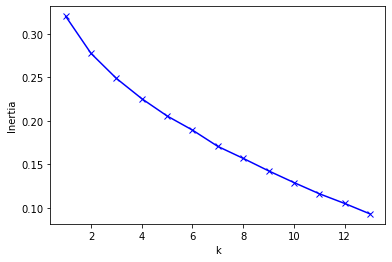

In [92]:
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()

We see that the optimal number of clusters is 3, 4 or 5. After trying with different values, even larger than 5, we decided to choose **--- 5 ---** and the results we obtain are shown below.

In [93]:
# set number of clusters
kclusters = 5

neighborhoods_SF_grouped_clustering_2 = neighborhoods_SF_grouped_2.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(init="k-means++", n_clusters=kclusters, n_init=1000, random_state=0).fit(neighborhoods_SF_grouped_clustering_2)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([4, 0, 0, 1, 1, 1, 0, 0, 0, 3], dtype=int32)

Let us create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [94]:
# add clustering labels
neighborhoods_venues_sorted_2.insert(0, 'Cluster Labels', kmeans.labels_)

neighborhoods_SF_merged_2 = neighborhoods_SF_coord[neighborhoods_SF_coord['Neighborhood'].isin(neighborhoods_SF_selected_cluster_list)]

neighborhoods_SF_merged_2 = neighborhoods_SF_merged_2.join(neighborhoods_venues_sorted_2.set_index('Neighborhood'), on='Neighborhood')

neighborhoods_SF_merged_2.head() # check the last columns!

Neighborhood   Latitude   Longitude  Cluster Labels  \
5            Lakeshore  37.721792 -122.485235               3   
8         Inner Sunset  37.759378 -122.464949               0   
9   West of Twin Peaks  37.738654 -122.460251               0   
11    Presidio Heights  37.786584 -122.452987               2   
12      Haight-Ashbury  37.768484 -122.445012               0   

   1st Most Common Venue   2nd Most Common Venue 3rd Most Common Venue  \
5              Juice Bar                    Café           Candy Store   
8                  Trail             Coffee Shop                  Park   
9            Coffee Shop             Pizza Place          Burger Joint   
11        Cosmetics Shop  Furniture / Home Store    Italian Restaurant   
12                  Park             Coffee Shop                  Café   

   4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
5                   Park        Cosmetics Shop        Sandwich Place   
8       Sushi Restaurant                Bakery        Ice Cream Shop   
9     Mexican Restaurant              Bus Line            Playground   
11           Coffee Shop   American Restaurant           Golf Course   
12        Ice Cream Shop           Yoga Studio         Grocery Store   

   7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
5         Clothing Store    Mexican Restaurant                   Gym   
8         Sandwich Place                Garden           Art Gallery   
9                   Park                   Pub           Flower Shop   
11                Bakery        Scenic Lookout      Sculpture Garden   
12           Pizza Place            Shoe Store        Breakfast Spot   

   10th Most Common Venue  
5                   Trail  
8          Breakfast Spot  
9          Sandwich Place  
11     Burmese Restaurant  
12              Bookstore

Finally, we can visualize the resulting clusters on the San Francisco map below. Click on the circle markers to see a popup with the name of the neighborhood and the cluster number.

In [95]:
# create map
map_SF_sub_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, neighborhood, cluster in zip(neighborhoods_SF_merged_2['Latitude'], neighborhoods_SF_merged_2['Longitude'], neighborhoods_SF_merged_2['Neighborhood'], neighborhoods_SF_merged_2['Cluster Labels']):
    label = folium.Popup(str(neighborhood) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=['black'],
#         color=rainbow[cluster-1],
#         color=['red','orange','green','blue'],
        fill=True,
        fill_color=rainbow[len(rainbow)-1 - cluster],
#         fill_color=['red','orange','green','blue'],
        fill_opacity=1).add_to(map_SF_sub_clusters)
       
map_SF_sub_clusters

We see that the large cluster can be divided into 5 sub-clusters. The division is not even, one of the sub-clusters has half of the neighborhoods of the large cluster. In addition, two small sub-cluster with just 1 element are created corresponding to the neighborhoods "Lakeshore" and "Bayview". Notice also that the neighborhoods of the city center (north-east part of San Francisco) are grouped into two sub-clusters. In the next section, we will analyze more in details the content of each cluster.

---------

## 4.3. Analysis of the Clusters

Now, we can examine each cluster and determine the discriminating venue categories that distinguish each cluster.

## 4.3.1. Top 10 Most Common Venues per Neighborhood per Cluster

### Sub-Cluster 0

In [96]:
neighborhoods_SF_merged_2.loc[neighborhoods_SF_merged_2['Cluster Labels'] == 0, neighborhoods_SF_merged_2.columns[[0] + list(range(3, neighborhoods_SF_merged_2.shape[1]))]]

Neighborhood  Cluster Labels 1st Most Common Venue  \
8          Inner Sunset               0                 Trail   
9    West of Twin Peaks               0           Coffee Shop   
12       Haight-Ashbury               0                  Park   
14        Outer Mission               0    Mexican Restaurant   
19  Castro-Upper Market               0               Gay Bar   
20           Noe Valley               0                  Park   
22            Glen Park               0                  Café   
26              Mission               0                  Café   
27       Bernal Heights               0    Mexican Restaurant   
30          North Beach               0           Pizza Place   
34         Potrero Hill               0           Coffee Shop   

   2nd Most Common Venue 3rd Most Common Venue    4th Most Common Venue  \
8            Coffee Shop                  Park         Sushi Restaurant   
9            Pizza Place          Burger Joint       Mexican Restaurant   
12           Coffee Shop                  Café           Ice Cream Shop   
14           Coffee Shop                  Park           Sandwich Place   
19                  Park           Coffee Shop  New American Restaurant   
20                  Café           Coffee Shop                Gift Shop   
22                  Park           Pizza Place           Breakfast Spot   
26    Mexican Restaurant          Cocktail Bar              Coffee Shop   
27           Coffee Shop                  Café               Playground   
30    Seafood Restaurant                  Park              Coffee Shop   
34                  Park           Art Gallery                     Café   

      5th Most Common Venue    6th Most Common Venue  \
8                    Bakery           Ice Cream Shop   
9                  Bus Line               Playground   
12              Yoga Studio            Grocery Store   
14       Chinese Restaurant                   Bakery   
19        Indian Restaurant          Thai Restaurant   
20               Playground                    Trail   
22                   Bakery                    Trail   
26  New American Restaurant            Deli / Bodega   
27            Grocery Store                     Park   
30       Italian Restaurant  New American Restaurant   
34                  Brewery                 Wine Bar   

        7th Most Common Venue      8th Most Common Venue  \
8              Sandwich Place                     Garden   
9                        Park                        Pub   
12                Pizza Place                 Shoe Store   
14                       Café                Pizza Place   
19                  Juice Bar              Deli / Bodega   
20                  Wine Shop                     Bakery   
22  Latin American Restaurant                  Gift Shop   
26                Music Venue  Latin American Restaurant   
27               Cocktail Bar                Pizza Place   
30                     Bakery                       Café   
34             Breakfast Spot                     Bakery   

   9th Most Common Venue     10th Most Common Venue  
8            Art Gallery             Breakfast Spot  
9            Flower Shop             Sandwich Place  
12        Breakfast Spot                  Bookstore  
14         Deli / Bodega  Latin American Restaurant  
19             Pet Store   Mediterranean Restaurant  
20    Italian Restaurant           Sushi Restaurant  
22         Grocery Store         Mexican Restaurant  
26        Ice Cream Shop                        Gym  
27    Italian Restaurant                   Dive Bar  
30         Deli / Bodega               Cocktail Bar  
34               Dog Run                Pizza Place

### Sub-Cluster 1

In [97]:
neighborhoods_SF_merged_2.loc[neighborhoods_SF_merged_2['Cluster Labels'] == 1, neighborhoods_SF_merged_2.columns[[0] + list(range(3, neighborhoods_SF_merged_2.shape[1]))]]

Neighborhood  Cluster Labels 1st Most Common Venue  \
25  Downtown-Tenderloin               1           Coffee Shop   
31            Chinatown               1           Coffee Shop   
32   Financial District               1           Coffee Shop   
33      South of Market               1           Coffee Shop   

    2nd Most Common Venue 3rd Most Common Venue    4th Most Common Venue  \
25  Vietnamese Restaurant                Bakery                  Theater   
31                  Hotel           Men's Store       Chinese Restaurant   
32                    Gym                  Café               Food Truck   
33            Pizza Place  Gym / Fitness Center  New American Restaurant   

       5th Most Common Venue    6th Most Common Venue 7th Most Common Venue  \
25            Sandwich Place     Marijuana Dispensary       Thai Restaurant   
31               Pizza Place  New American Restaurant                  Café   
32  Mediterranean Restaurant                 Boutique     French Restaurant   
33                      Café                 Wine Bar               Brewery   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
25          Cocktail Bar           Art Gallery         Massage Studio  
31                   Gym    Italian Restaurant           Cocktail Bar  
32           Men's Store      Sushi Restaurant                 Museum  
33  Marijuana Dispensary            Restaurant                 Bakery

### Sub-Cluster 2 

In [98]:
neighborhoods_SF_merged_2.loc[neighborhoods_SF_merged_2['Cluster Labels'] == 2, neighborhoods_SF_merged_2.columns[[0] + list(range(3, neighborhoods_SF_merged_2.shape[1]))]]

Neighborhood  Cluster Labels 1st Most Common Venue  \
11  Presidio Heights               2        Cosmetics Shop   
16            Marina               2  Gym / Fitness Center   
17   Pacific Heights               2    Italian Restaurant   
18  Western Addition               2                Bakery   
23      Russian Hill               2                  Park   
24          Nob Hill               2    Italian Restaurant   

     2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
11  Furniture / Home Store    Italian Restaurant           Coffee Shop   
16       French Restaurant              Wine Bar    Italian Restaurant   
17          Cosmetics Shop                Bakery                  Park   
18                Tea Room        Ice Cream Shop                  Park   
23      Italian Restaurant        Chocolate Shop                   Bar   
24   Vietnamese Restaurant              Wine Bar           Coffee Shop   

       5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
11       American Restaurant           Golf Course                Bakery   
16            Sandwich Place           Coffee Shop        Cosmetics Shop   
17            Sandwich Place              Boutique              Wine Bar   
18             Grocery Store      Sushi Restaurant             Bookstore   
23  Bike Rental / Bike Share                  Café           Coffee Shop   
24               Yoga Studio           Pizza Place                  Park   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
11        Scenic Lookout      Sculpture Garden     Burmese Restaurant  
16                  Park    Mexican Restaurant       Sushi Restaurant  
17     French Restaurant        Ice Cream Shop            Yoga Studio  
18           Pizza Place        Cosmetics Shop       Ramen Restaurant  
23        Ice Cream Shop           Pizza Place         Sandwich Place  
24                   Bar      Sushi Restaurant          Deli / Bodega

### Sub-Cluster 3 

In [99]:
neighborhoods_SF_merged_2.loc[neighborhoods_SF_merged_2['Cluster Labels'] == 3, neighborhoods_SF_merged_2.columns[[0] + list(range(3, neighborhoods_SF_merged_2.shape[1]))]]

Neighborhood  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
5    Lakeshore               3             Juice Bar                  Café   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
5           Candy Store                  Park        Cosmetics Shop   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
5        Sandwich Place        Clothing Store    Mexican Restaurant   

  9th Most Common Venue 10th Most Common Venue  
5                   Gym                  Trail

### Sub-Cluster 4 

In [100]:
neighborhoods_SF_merged_2.loc[neighborhoods_SF_merged_2['Cluster Labels'] == 4, neighborhoods_SF_merged_2.columns[[0] + list(range(3, neighborhoods_SF_merged_2.shape[1]))]]

Neighborhood  Cluster Labels            1st Most Common Venue  \
35      Bayview               4  Southern / Soul Food Restaurant   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
35           Coffee Shop    Mexican Restaurant                Bakery   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
35    Light Rail Station              Pharmacy    Chinese Restaurant   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
35       Motorcycle Shop                Garden  General Entertainment

-------

### Discussion

From this first analysis, we can say that __Sub-Cluster 0__ is the largest and it is rather miscellaneous. The dominant categories seem to be "Café", "Park", and "Coffee shop". On the other hand, in the __Sub-Cluster 1__ coffee shops are the dominant venues. __Sub-Cluster 2__ is also miscellaneous with many Italian restaurants. Finally, __Sub-Cluster 3__ and __Sub-Cluster 4__ have only the neighborhoods "Lakeshore" and "Bayview", respectively. Both these sub-clusters are characterized by venues with mixed categories and we see that they do not have that much in common with the other clusters. In other words, it seems fine that they are two distinct sub-clusters.

-----------

## 4.3.2. Total Venues per Category per Cluster

In order to have a better understanding of the most common venues in each cluster, we consider here the total number of venues grouped per category in each cluster. This analysis will help us to decide the name/label to give to a cluster.

We start from the dataframe *neighborhoods_SF_onehot_tot* containing the One Hot Encoding, then we group by clusters and sum over the categories as follows.

In [101]:
neighborhoods_SF_onehot_tot.head()

Neighborhood  Zoo Exhibit  ATM  Acai House  Accessories Store  \
0              Bayview            0    0           0                  0   
1       Bernal Heights            0    0           0                  0   
2  Castro-Upper Market            0    0           0                  0   
3            Chinatown            0    0           0                  0   
4       Crocker Amazon            0    0           0                  0   

   Adult Boutique  African Restaurant  Alternative Healer  \
0               0                   1                   0   
1               0                   0                   0   
2               0                   0                   0   
3               0                   0                   0   
4               0                   0                   0   

   American Restaurant  Antique Shop  Arcade  Argentinian Restaurant  \
0                    0             0       0                       0   
1                    1             0       0                       0   
2                    1             0       1                       0   
3                    1             0       0                       0   
4                    1             0       0                       0   

   Art Gallery  Art Museum  Arts & Crafts Store  Asian Restaurant  \
0            0           0                    0                 0   
1            1           0                    0                 1   
2            0           0                    1                 0   
3            0           0                    1                 1   
4            0           0                    0                 1   

   Athletics & Sports  Automotive Shop  BBQ Joint  Baby Store  Bagel Shop  \
0                   0                0          0           0           0   
1                   0                0          1           0           0   
2                   0                0          0           0           0   
3                   0                0          0           0           0   
4                   0                0          0           0           0   

   Bakery  Bank  Bar  Baseball Field  Baseball Stadium  Basketball Court  \
0       3     0    0               0                 0                 0   
1       2     0    0               0                 0                 0   
2       2     0    0               0                 0                 0   
3       2     0    2               0                 0                 0   
4       1     0    1               3                 0                 1   

   Bath House  Beach  Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  \
0           0      0                0         0            0           0   
1           0      0                0         1            0           0   
2           0      0                0         0            0           0   
3           0      0                0         0            0           0   
4           0      0                0         0            0           0   

   Big Box Store  Bike Rental / Bike Share  Bike Shop  Bike Trail  Bistro  \
0              0                         0          0           0       0   
1              0                         0          0           0       0   
2              0                         0          0           0       0   
3              0                         0          0           0       0   
4              0                         0          0           0       0   

   Board Shop  Bookstore  Botanical Garden  Boutique  Bowling Alley  \
0           0          0                 0         0              0   
1           0          0                 0         0              0   
2           0          1                 0         0              0   
3           0          2                 0         1              0   
4           0          0                 0         0              0   

   Bowling Green  Boxing Gym  Brazilian Restaurant  Breakfast Spot  Brewery  

In [102]:
neighborhoods_SF_onehot_tot.shape

(37, 326)

In [103]:
neighborhoods_SF_merged_2.head()

Neighborhood   Latitude   Longitude  Cluster Labels  \
5            Lakeshore  37.721792 -122.485235               3   
8         Inner Sunset  37.759378 -122.464949               0   
9   West of Twin Peaks  37.738654 -122.460251               0   
11    Presidio Heights  37.786584 -122.452987               2   
12      Haight-Ashbury  37.768484 -122.445012               0   

   1st Most Common Venue   2nd Most Common Venue 3rd Most Common Venue  \
5              Juice Bar                    Café           Candy Store   
8                  Trail             Coffee Shop                  Park   
9            Coffee Shop             Pizza Place          Burger Joint   
11        Cosmetics Shop  Furniture / Home Store    Italian Restaurant   
12                  Park             Coffee Shop                  Café   

   4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
5                   Park        Cosmetics Shop        Sandwich Place   
8       Sushi Restaurant                Bakery        Ice Cream Shop   
9     Mexican Restaurant              Bus Line            Playground   
11           Coffee Shop   American Restaurant           Golf Course   
12        Ice Cream Shop           Yoga Studio         Grocery Store   

   7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
5         Clothing Store    Mexican Restaurant                   Gym   
8         Sandwich Place                Garden           Art Gallery   
9                   Park                   Pub           Flower Shop   
11                Bakery        Scenic Lookout      Sculpture Garden   
12           Pizza Place            Shoe Store        Breakfast Spot   

   10th Most Common Venue  
5                   Trail  
8          Breakfast Spot  
9          Sandwich Place  
11     Burmese Restaurant  
12              Bookstore

In [104]:
neighborhoods_SF_merged_2.shape

(23, 14)

In [105]:
neighborhoods_SF_merged_clusters_sub = neighborhoods_SF_merged_2[['Neighborhood','Cluster Labels']]
neighborhoods_SF_merged_clusters_sub.head()

Neighborhood  Cluster Labels
5            Lakeshore               3
8         Inner Sunset               0
9   West of Twin Peaks               0
11    Presidio Heights               2
12      Haight-Ashbury               0

In [106]:
neighborhoods_SF_merged_tot_clusters_sub = neighborhoods_SF_merged_clusters_sub.join(neighborhoods_SF_onehot_tot.set_index('Neighborhood'), on='Neighborhood', how='left')

neighborhoods_SF_merged_tot_clusters_sub.head()

Neighborhood  Cluster Labels  Zoo Exhibit  ATM  Acai House  \
5            Lakeshore               3            0    0           0   
8         Inner Sunset               0            0    0           0   
9   West of Twin Peaks               0            0    0           0   
11    Presidio Heights               2            0    1           0   
12      Haight-Ashbury               0            0    0           0   

    Accessories Store  Adult Boutique  African Restaurant  Alternative Healer  \
5                   1               0                   0                   0   
8                   0               0                   0                   0   
9                   0               0                   0                   0   
11                  1               0                   0                   0   
12                  2               0                   0                   0   

    American Restaurant  Antique Shop  Arcade  Argentinian Restaurant  \
5                     1             0       0                       0   
8                     0             0       0                       0   
9                     0             0       0                       0   
11                    3             0       0                       0   
12                    0             0       1                       0   

    Art Gallery  Art Museum  Arts & Crafts Store  Asian Restaurant  \
5             0           0                    0                 0   
8             2           0                    0                 1   
9             0           0                    0                 0   
11            1           0                    0                 1   
12            0           0                    1                 0   

    Athletics & Sports  Automotive Shop  BBQ Joint  Baby Store  Bagel Shop  \
5                    0                0          0           0           0   
8                    0                0          0           0           0   
9                    0                0          0           0           0   
11                   0                0          0           1           0   
12                   0                0          0           0           0   

    Bakery  Bank  Bar  Baseball Field  Baseball Stadium  Basketball Court  \
5        1     0    0               0                 0                 0   
8        4     0    0               1                 0                 0   
9        1     1    1               0                 0                 0   
11       3     2    0               1                 0                 0   
12       0     0    1               0                 0                 0   

    Bath House  Beach  Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  \
5            0      0                0         0            0           0   
8            0      0                0         0            0           0   
9            0      0                0         0            0           0   
11           0      0                0         0            0           0   
12           0      0                0         0            0           0   

    Big Box Store  Bike Rental / Bike Share  Bike Shop  Bike Trail  Bistro  \
5               0                         0          0           0       0   
8               0                         0          0           0       0   
9               0                         0          0           0       0   
11              1                         0          0           0       0   
12              0                         0          0           0       0   

    Board Shop  Bookstore  Botanical Garden  Boutique  Bowling Alley  \
5            0          0                 0         1              0   
8            0          1                 1         0              0   
9            0          1                 0         0              0   
11           0          1                 0         0              0   
12    

In [107]:
neighborhoods_SF_merged_tot_clusters_sub.shape

(23, 327)

In [108]:
neighborhoods_SF_merged_tot_clusters_only_sub = neighborhoods_SF_merged_tot_clusters_sub.drop(['Neighborhood'],axis=1)
neighborhoods_SF_merged_tot_clusters_only_sub.head()

Cluster Labels  Zoo Exhibit  ATM  Acai House  Accessories Store  \
5                3            0    0           0                  1   
8                0            0    0           0                  0   
9                0            0    0           0                  0   
11               2            0    1           0                  1   
12               0            0    0           0                  2   

    Adult Boutique  African Restaurant  Alternative Healer  \
5                0                   0                   0   
8                0                   0                   0   
9                0                   0                   0   
11               0                   0                   0   
12               0                   0                   0   

    American Restaurant  Antique Shop  Arcade  Argentinian Restaurant  \
5                     1             0       0                       0   
8                     0             0       0                       0   
9                     0             0       0                       0   
11                    3             0       0                       0   
12                    0             0       1                       0   

    Art Gallery  Art Museum  Arts & Crafts Store  Asian Restaurant  \
5             0           0                    0                 0   
8             2           0                    0                 1   
9             0           0                    0                 0   
11            1           0                    0                 1   
12            0           0                    1                 0   

    Athletics & Sports  Automotive Shop  BBQ Joint  Baby Store  Bagel Shop  \
5                    0                0          0           0           0   
8                    0                0          0           0           0   
9                    0                0          0           0           0   
11                   0                0          0           1           0   
12                   0                0          0           0           0   

    Bakery  Bank  Bar  Baseball Field  Baseball Stadium  Basketball Court  \
5        1     0    0               0                 0                 0   
8        4     0    0               1                 0                 0   
9        1     1    1               0                 0                 0   
11       3     2    0               1                 0                 0   
12       0     0    1               0                 0                 0   

    Bath House  Beach  Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  \
5            0      0                0         0            0           0   
8            0      0                0         0            0           0   
9            0      0                0         0            0           0   
11           0      0                0         0            0           0   
12           0      0                0         0            0           0   

    Big Box Store  Bike Rental / Bike Share  Bike Shop  Bike Trail  Bistro  \
5               0                         0          0           0       0   
8               0                         0          0           0       0   
9               0                         0          0           0       0   
11              1                         0          0           0       0   
12              0                         0          0           0       0   

    Board Shop  Bookstore  Botanical Garden  Boutique  Bowling Alley  \
5            0          0                 0         1              0   
8            0          1                 1         0              0   
9            0          1                 0         0              0   
11           0          1                 0         0              0   
12           1          3                 0         3              0   

    Bowling Green  Boxing Gym  Brazilian Restau

In [109]:
neighborhoods_SF_merged_tot_clusters_only_sub.shape

(23, 326)

In [110]:
neighborhoods_SF_merged_tot_clusters_only_grouped_sub = neighborhoods_SF_merged_tot_clusters_only_sub.groupby('Cluster Labels').sum()
neighborhoods_SF_merged_tot_clusters_only_grouped_sub.head()

Zoo Exhibit  ATM  Acai House  Accessories Store  \
Cluster Labels                                                    
0                         1    0           0                  5   
1                         0    0           1                  1   
2                         0    1           0                  3   
3                         0    0           0                  1   
4                         0    0           0                  0   

                Adult Boutique  African Restaurant  Alternative Healer  \
Cluster Labels                                                           
0                            1                   0                   1   
1                            0                   0                   1   
2                            0                   0                   1   
3                            0                   0                   0   
4                            0                   1                   0   

                American Restaurant  Antique Shop  Arcade  \
Cluster Labels                                              
0                                11             2       2   
1                                 1             0       0   
2                                 7             0       0   
3                                 1             0       0   
4                                 0             0       0   

                Argentinian Restaurant  Art Gallery  Art Museum  \
Cluster Labels                                                    
0                                    3           11           1   
1                                    0            6           5   
2                                    0            5           1   
3                                    0            0           0   
4                                    0            0           0   

                Arts & Crafts Store  Asian Restaurant  Athletics & Sports  \
Cluster Labels                                                              
0                                 5                 5                   0   
1                                 4                 1                   0   
2                                 5                 3                   1   
3                                 0                 0                   0   
4                                 0                 0                   0   

                Automotive Shop  BBQ Joint  Baby Store  Bagel Shop  Bakery  \
Cluster Labels                                                               
0                             0          2           0           0      27   
1                             0          0           0           0       9   
2                             0          1           1           1      17   
3                             0          0           0           0       1   
4                             0          0           0           0       3   

                Bank  Bar  Baseball Field  Baseball Stadium  Basketball Court  \
Cluster Labels                                                                  
0                  3   10               2                 0                 0   
1                  0    4               0                 1                 1   
2                  2    9               2                 0                 0   
3                  0    0               0                 0                 0   
4                  0    0               0                 0                 0   

                Bath House  Beach  Bed & Breakfast  Beer Bar  Beer Garden  \
Cluster Labels                                                              
0                        0      0                1         4            0   
1                        0      0                0         2            0   
2                        1      1                0         1            1   
3                        0      0                0         0            0   
4           

In [111]:
neighborhoods_SF_merged_tot_clusters_only_grouped_sub.reset_index(inplace=True, drop=True)

------------

### Sub-Cluster 0 - Coffee places (Italian and Mexican cuisine, parks)

In [112]:
neighborhoods_SF_merged_tot_clusters_only_grouped_sub[0:1].sort_values(by=0,ascending=False,axis=1).T.head(20)

0
Coffee Shop              50
Park                     44
Café                     39
Pizza Place              30
Mexican Restaurant       29
Bakery                   27
Trail                    24
Grocery Store            22
Breakfast Spot           19
Italian Restaurant       17
Playground               16
Indian Restaurant        15
Ice Cream Shop           15
Gift Shop                15
Sandwich Place           15
Bookstore                15
Deli / Bodega            15
Sushi Restaurant         15
New American Restaurant  14
Cocktail Bar             14

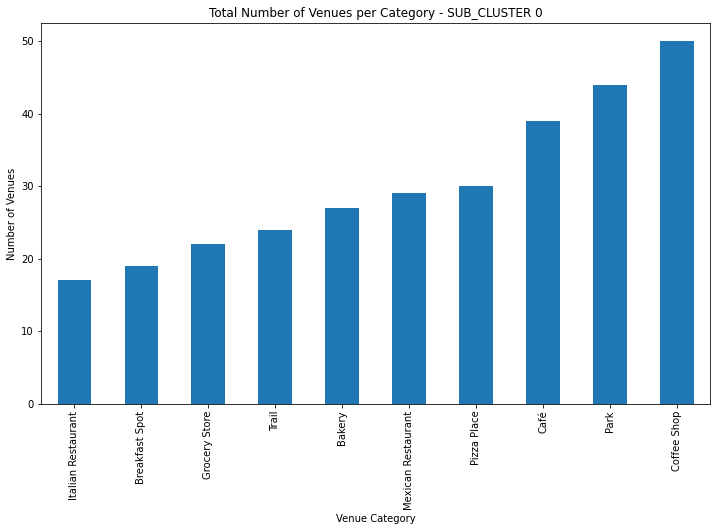

In [113]:
neighborhoods_SF_merged_tot_clusters_only_grouped_sub[0:1].sort_values(by=0,ascending=True,axis=1).T.tail(10).plot(kind='bar', figsize=(12, 7))

plt.xlabel('Venue Category') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Total Number of Venues per Category - SUB_CLUSTER 0') # add title to the plot
plt.legend('',frameon=False)

plt.show()

### Sub-Cluster 1 - Coffee places (Fitness, Hotels)

In [114]:
neighborhoods_SF_merged_tot_clusters_only_grouped_sub[1:2].sort_values(by=1,ascending=False,axis=1).T.head(20)

1
Coffee Shop              46
Café                     13
Gym                      12
Hotel                    11
Pizza Place              10
Bakery                    9
Gym / Fitness Center      9
New American Restaurant   9
Wine Bar                  9
Sushi Restaurant          9
Restaurant                8
Vietnamese Restaurant     8
Sandwich Place            8
Cocktail Bar              7
Men's Store               7
Park                      7
Marijuana Dispensary      7
Food Truck                6
Spa                       6
Art Gallery               6

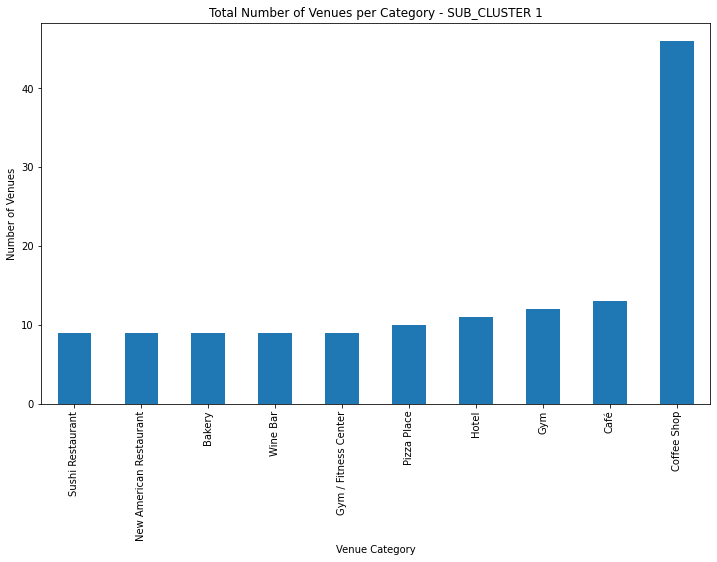

In [115]:
neighborhoods_SF_merged_tot_clusters_only_grouped_sub[1:2].sort_values(by=1,ascending=True,axis=1).T.tail(10).plot(kind='bar', figsize=(12, 7))

plt.xlabel('Venue Category') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Total Number of Venues per Category - SUB_CLUSTER 1') # add title to the plot
plt.legend('',frameon=False)

plt.show()

### Sub-Cluster 2 - Italian cuisine (coffee places, parks)

In [116]:
neighborhoods_SF_merged_tot_clusters_only_grouped_sub[2:3].sort_values(by=2,ascending=False,axis=1).T.head(20)

2
Italian Restaurant     28
Park                   20
Bakery                 17
Coffee Shop            16
Cosmetics Shop         16
Wine Bar               15
Gym / Fitness Center   13
Ice Cream Shop         12
Pizza Place            12
Sandwich Place         11
Sushi Restaurant       11
Café                   11
French Restaurant      10
Grocery Store           9
Bar                     9
Yoga Studio             9
Playground              8
Vietnamese Restaurant   8
American Restaurant     7
Bookstore               7

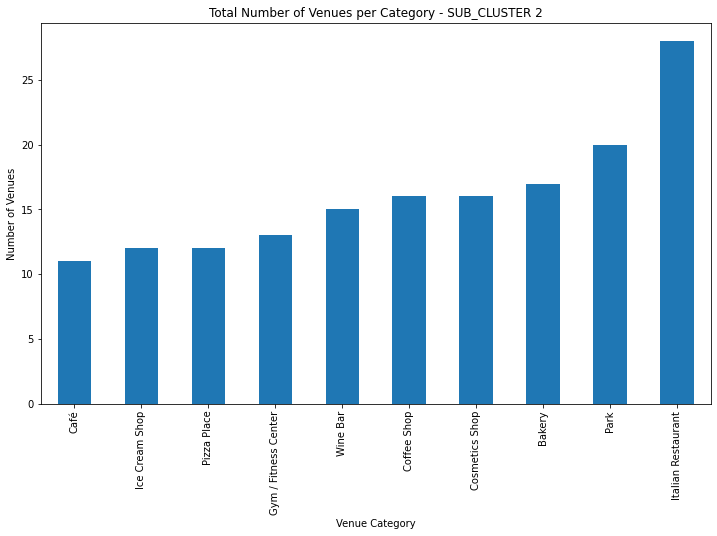

In [117]:
neighborhoods_SF_merged_tot_clusters_only_grouped_sub[2:3].sort_values(by=2,ascending=True,axis=1).T.tail(10).plot(kind='bar', figsize=(12, 7))

plt.xlabel('Venue Category') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Total Number of Venues per Category - SUB_CLUSTER 2') # add title to the plot
plt.legend('',frameon=False)

plt.show()

### Sub-Cluster 3 - Miscellaneous (Lakeshore)

In [118]:
neighborhoods_SF_merged_tot_clusters_only_grouped_sub[3:4].sort_values(by=3,ascending=False,axis=1).T.head(20)

3
Juice Bar           3
Café                3
Candy Store         3
Park                3
Trail               2
Cosmetics Shop      2
Gym                 2
Mexican Restaurant  2
Clothing Store      2
Snack Place         2
Sandwich Place      2
Church              1
Sushi Restaurant    1
Pizza Place         1
Shopping Mall       1
Bubble Tea Shop     1
Lingerie Store      1
Supplement Shop     1
Tennis Court        1
Cocktail Bar        1

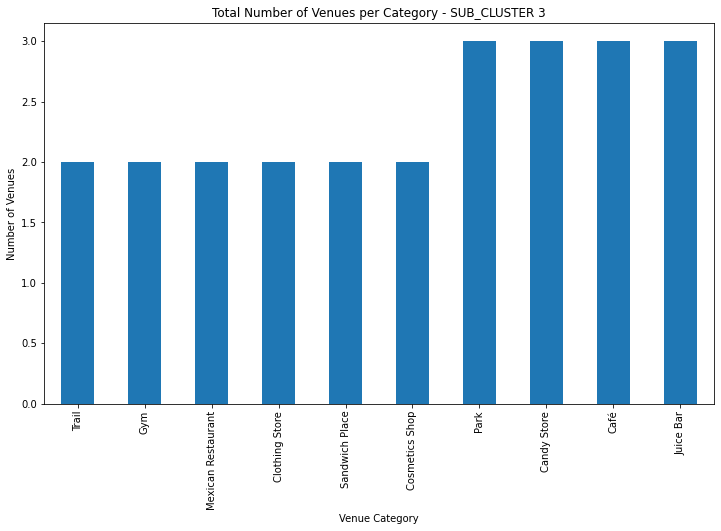

In [119]:
neighborhoods_SF_merged_tot_clusters_only_grouped_sub[3:4].sort_values(by=3,ascending=True,axis=1).T.tail(10).plot(kind='bar', figsize=(12, 7))

plt.xlabel('Venue Category') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Total Number of Venues per Category - SUB_CLUSTER 3') # add title to the plot
plt.legend('',frameon=False)

plt.show()

### Sub-Cluster 4 - Miscellaneous (Bayview)

In [120]:
neighborhoods_SF_merged_tot_clusters_only_grouped_sub[4:5].sort_values(by=4,ascending=False,axis=1).T.head(20)

4
Coffee Shop                      4
Southern / Soul Food Restaurant  4
Mexican Restaurant               4
Bakery                           3
Light Rail Station               2
Chinese Restaurant               2
Pharmacy                         2
Construction & Landscaping       1
Flower Shop                      1
Thrift / Vintage Store           1
Theater                          1
Hawaiian Restaurant              1
Brewery                          1
Pizza Place                      1
Non-Profit                       1
Fried Chicken Joint              1
Gym                              1
Grocery Store                    1
Restaurant                       1
Burger Joint                     1

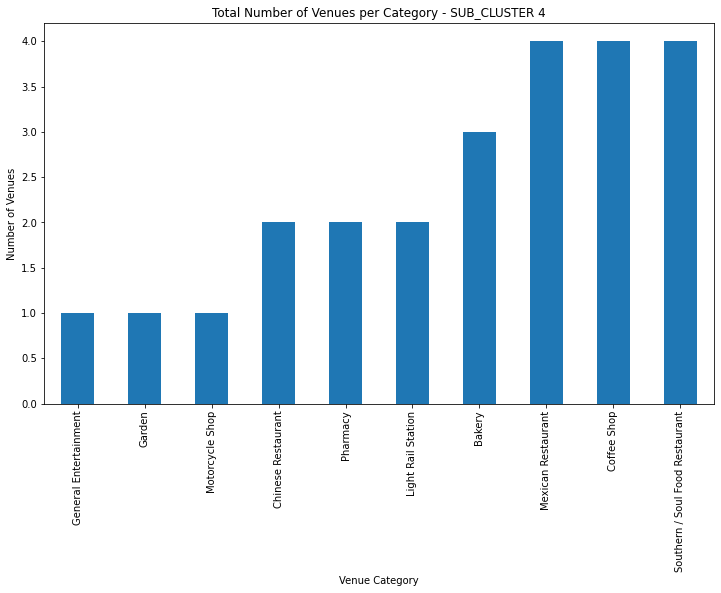

In [134]:
neighborhoods_SF_merged_tot_clusters_only_grouped_sub[4:5].sort_values(by=4,ascending=True,axis=1).T.tail(10).plot(kind='bar', figsize=(12, 7))

plt.xlabel('Venue Category') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Total Number of Venues per Category - SUB_CLUSTER 4') # add title to the plot
plt.legend('',frameon=False)

plt.show()

---------------------

### Discussion

Thanks to the analysis of the most common venues carried out above, we label the 5 sub-clusters as follows:

- Sub-Cluster 0 - Coffee places (Italian and Mexican cuisine, parks)
- Sub-Cluster 1 - Coffee places (Fitness, Hotels)
- Sub-Cluster 2 - Italian cuisine (coffee places, parks)
- Sub-Cluster 3 - Miscellaneous (Lakeshore)
- Sub-Cluster 4 - Miscellaneous (Bayview)

We notice first of all that __Sub-Cluster 0__ is the largest, it has mainly coffee shops but also other kind of venues are commonly reachable in its neighborhoods. A better understanding could be achieved by sub-clustering __Sub-Cluster 0__, but this is out of the scope of this project.

Special attention is required by __Sub-Cluster 3__ and __Sub-Cluster 4__ which have only the neighborhoods "Lakeshore" and "Bayview", respectively. In fact, they contain miscellaneous venues and are clearly distinct from the other sub-clusters. They seem quite peculiar.

---------------

<a id='item5'></a>

## 5. Merging Clusters and Sub-Clusters

We are now in a position to merge clusters and subclusters in one San Francisco map which summarizes our findings.

The list of neighborhoods in the "large" cluster is

In [122]:
neighborhoods_SF_selected_cluster_list

['Lakeshore',
 'Inner Sunset',
 'West of Twin Peaks',
 'Presidio Heights',
 'Haight-Ashbury',
 'Outer Mission',
 'Marina',
 'Pacific Heights',
 'Western Addition',
 'Castro-Upper Market',
 'Noe Valley',
 'Glen Park',
 'Russian Hill',
 'Nob Hill',
 'Downtown-Tenderloin',
 'Mission',
 'Bernal Heights',
 'North Beach',
 'Chinatown',
 'Financial District',
 'South of Market',
 'Potrero Hill',
 'Bayview']

In [123]:
len(neighborhoods_SF_selected_cluster_list)

23

We create a new dataframe without these selected neighborhoods using *neighborhoods_SF_merged* :

In [124]:
neighborhoods_SF_merged.head()

Neighborhood   Latitude   Longitude  Cluster Labels  \
0          Seacliff  37.784973 -122.501423               2   
1    Outer Richmond  37.777818 -122.492410               1   
2  Golden Gate Park  37.769383 -122.481940               1   
3      Outer Sunset  37.755419 -122.493805               1   
4          Parkside  37.742096 -122.489641               1   

  1st Most Common Venue  2nd Most Common Venue 3rd Most Common Venue  \
0                 Trail                   Café   Monument / Landmark   
1    Chinese Restaurant                   Café                Bakery   
2                  Park  Vietnamese Restaurant       Bubble Tea Shop   
3    Chinese Restaurant           Liquor Store           Coffee Shop   
4    Chinese Restaurant    Dumpling Restaurant                  Park   

   4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0               Pharmacy              Bus Stop        Scenic Lookout   
1  Vietnamese Restaurant            Playground     Korean Restaurant   
2     Chinese Restaurant                Bakery         Deli / Bodega   
3    Japanese Restaurant    Light Rail Station  Gym / Fitness Center   
4         Sandwich Place              Pharmacy           Supermarket   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0                  Park                 Beach      Sculpture Garden   
1      Sushi Restaurant         Deli / Bodega   Japanese Restaurant   
2   Dumpling Restaurant                Garden           Coffee Shop   
3                  Café        Cosmetics Shop             Pet Store   
4       Thai Restaurant       Bubble Tea Shop        Baseball Field   

  10th Most Common Venue  
0                  Motel  
1          Burrito Place  
2             Playground  
3           Dessert Shop  
4                    Bar

In [125]:
neighborhoods_SF_merged.shape

(37, 14)

In [126]:
neighborhoods_SF_merged_no_selected = neighborhoods_SF_merged.set_index('Neighborhood').T.drop(neighborhoods_SF_selected_cluster_list,axis=1).T.reset_index()
neighborhoods_SF_merged_no_selected

Neighborhood Latitude Longitude Cluster Labels 1st Most Common Venue  \
0            Seacliff   37.785  -122.501              2                 Trail   
1      Outer Richmond  37.7778  -122.492              1    Chinese Restaurant   
2    Golden Gate Park  37.7694  -122.482              1                  Park   
3        Outer Sunset  37.7554  -122.494              1    Chinese Restaurant   
4            Parkside  37.7421   -122.49              1    Chinese Restaurant   
5            Presidio  37.7977  -122.468              2                 Trail   
6      Inner Richmond   37.779  -122.467              1                Bakery   
7           Oceanview  37.7182  -122.462              1           Yoga Studio   
8          Twin-Peaks  37.7528  -122.451              3                 Trail   
9      Crocker Amazon  37.7118  -122.439              1           Pizza Place   
10    Diamond Heights  37.7424  -122.441              3                  Park   
11          Excelsior  37.7263  -122.422              2                  Park   
12  Visitacion Valley  37.7149  -122.413              2         Grocery Store   
13    Treasure Island  37.8214  -122.369              4            Food Truck   

    2nd Most Common Venue 3rd Most Common Venue  4th Most Common Venue  \
0                    Café   Monument / Landmark               Pharmacy   
1                    Café                Bakery  Vietnamese Restaurant   
2   Vietnamese Restaurant       Bubble Tea Shop     Chinese Restaurant   
3            Liquor Store           Coffee Shop    Japanese Restaurant   
4     Dumpling Restaurant                  Park         Sandwich Place   
5                    Park                  Café         Scenic Lookout   
6      Chinese Restaurant   Japanese Restaurant                 Garden   
7      Chinese Restaurant      Asian Restaurant            Pizza Place   
8                    Park              Bus Stop         Scenic Lookout   
9            Liquor Store    Mexican Restaurant         Baseball Field   
10                  Trail            Playground            Coffee Shop   
11                Dog Run        Baseball Field      Convenience Store   
12                   Park                 Trail                 Garden   
13     Athletics & Sports       Harbor / Marina         Baseball Field   

   5th Most Common Venue 6th Most Common Venue  7th Most Common Venue  \
0               Bus Stop        Scenic Lookout                   Park   
1             Playground     Korean Restaurant       Sushi Restaurant   
2                 Bakery         Deli / Bodega    Dumpling Restaurant   
3     Light Rail Station  Gym / Fitness Center                   Café   
4               Pharmacy           Supermarket        Thai Restaurant   
5                 Tunnel                Museum         Baseball Field   
6                   Café     Korean Restaurant        Thai Restaurant   
7    Japanese Restaurant           Coffee Shop          Grocery Store   
8     Light Rail Station             Reservoir                   Hill   
9     Chinese Restaurant            Playground  Vietnamese Restaurant   
10        Scenic Lookout               Theater        Thai Restaurant   
11                  Farm                 Trail         Scenic Lookout   
12           Bus Station    Chinese Restaurant             Bike Trail   
13           Music Venue                 Beach                   Park   

        8th Most Common Venue  9th Most Common Venue 10th Most Common Venue  
0                       Beach       Sculpture Garden                  Motel  
1               Deli / Bodega    Japanese Restaurant          Burrito Place  
2                      Garden            Coffee Shop             Playground  
3              Cosmetics Shop              Pet Store           Dessert Shop  
4             Bubble Tea Shop         Baseball Field                    Bar  
5                  Food Truck  General Entertainment                  Plaza  
6          Burmese Restaurant  Vietnames

In [127]:
neighborhoods_SF_merged_no_selected.shape

(14, 14)

We can now create the desired map with clusters and sub-clusters. See below. Click on the circle markers to see a popup with the name of the neighborhood and the cluster or sub-cluster number.

In [133]:
# create map
map_SF_clusters_sub_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

kclusters_1 = 5
kclusters_2 = 5


# set color scheme for the clusters
x_1 = np.arange(kclusters_1)
ys_1 = [i + x_1 + (i*x_1)**2 for i in range(kclusters_1)]
# colors_array_1 = cm.rainbow(np.linspace(0, 0.5, len(ys_1)))
colors_array_1 = cm.rainbow(np.linspace(0, 0.4, len(ys_1)))
rainbow_1 = [colors.rgb2hex(i) for i in colors_array_1]

x_2 = np.arange(kclusters_2-1)
ys_2 = [i + x_2 + (i*x_2)**2 for i in range(kclusters_2)]
# colors_array_2 = cm.rainbow(np.linspace(0, 0.4, len(ys_2)))
colors_array_2 = cm.rainbow(np.linspace(1, 0.4, len(ys_2)))
rainbow_2 = [colors.rgb2hex(i) for i in colors_array_2]

cluster_color_marker = [0,1,2,3,4]
sub_cluster_color_marker = [5,6,7,8,9]


# add markers to the map
for lat, lon, neighborhood, cluster in zip(neighborhoods_SF_merged_no_selected['Latitude'], neighborhoods_SF_merged_no_selected['Longitude'], neighborhoods_SF_merged_no_selected['Neighborhood'], neighborhoods_SF_merged_no_selected['Cluster Labels']):
    label = folium.Popup(str(neighborhood) + ' - ' + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=['black'],
#         color=rainbow[cluster-1],
#         color=['red','orange','green','blue'],
        fill=True,
        fill_color=rainbow_1[cluster],
        fill_opacity=1).add_to(map_SF_clusters_sub_clusters)
    

# add markers to the map
for lat, lon, neighborhood, cluster in zip(neighborhoods_SF_merged_2['Latitude'], neighborhoods_SF_merged_2['Longitude'], neighborhoods_SF_merged_2['Neighborhood'], neighborhoods_SF_merged_2['Cluster Labels']):
    label = folium.Popup(str(neighborhood) + ' - ' + ' Sub-Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=['black'],
#         color=rainbow[cluster-1],
#         color=['red','orange','green','blue'],
        fill=True,
        fill_color=rainbow_2[cluster],
        fill_opacity=1).add_to(map_SF_clusters_sub_clusters)

    
map_SF_clusters_sub_clusters

----------------

<a id='item6'></a>

## 6. Conclusions

In this Notebook, we analyzed the neighborhoods of San Francisco in terms of the most common venues. We used the Foursquare API calls to get a list of the venues of each neighborhood, represented as a circle with radius of 1 km. We then applied the _k-means_ clustering method to group the neighborhoods in 5 clusters depending on the venues categories. We labelled them by considering the most common venues as follows:

- Cluster 0 - Coffee Places (Miscellaneous)
- Cluster 1 - Chinese Restaurants and Asian Cuisine (Vietnamese+Japanese+Korean)
- Cluster 2 - Trails, Parks, and Café
- Cluster 3 - Trails and Parks
- Cluster 4 - Food Trucks, Sport and Music Events Places

Here, Cluster 1 and Cluster 4 have a well defined label, whereas Cluster 2 and Cluster 3 could be actually one unique cluster. In addition, we found that Cluster 0 is over-represented and it has venues categories which are rather miscellaneous, mainly belonging to the "Coffee Shop" category. We decided then to cluster it separately and we obtained the following sub-clusters:

- Sub-Cluster 0 - Coffee places (Italian and Mexican cuisine, parks)
- Sub-Cluster 1 - Coffee places (Fitness, Hotels)
- Sub-Cluster 2 - Italian cuisine (coffee places, parks)
- Sub-Cluster 3 - Miscellaneous (Lakeshore)
- Sub-Cluster 4 - Miscellaneous (Bayview)

Here, Sub-Cluster 0 has half of the neighborhoods of the sub-clustered ones and it could be further clustered separately, but this is out of the scope of this project. On the other hand, Sub-Cluster 1 defines the neighborhoods in the city center where the presence of coffee places is dominant and where fitness centers and hotels are also common. Sub-Cluster 3 and Sub-Cluster 4 have a special variety of venues. They contain just 1 element namely the neighborhoods "Lakeshore" and "Bayview", respectively. The fact that these two big neighborhoods stand out from the others might be related to their peculiar geographical characteristics. In fact, "Lakeview" is identified by Lake Merced and the park around it whereas "Bayview" is represented mostly by the presence of the Hunters Point Naval Shipyard. 

--------------
--------------